# Training a Mini-GPT to Learn Two-Digit Addition

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Organized_Chaos-orange)
[![Code](https://img.shields.io/badge/View-Code-blue?style=flat-square&logo=github)](https://github.com/gao-hongnan/omniverse/tree/5221d5d8b9bd845568b2e323d908be282c6e8434/omnivault/transformer/projects/adder)


```{contents}
:local:
```

## Motivation

Generative Pre-trained Transformer (GPT) are well known to perform bad on
arithmetic tasks such as addition. This should not come as a surprise since GPT
is a _language_ model and not a _math_ model. It is designed to train on a large
corpus of text and learn the patterns and structure of natural language. While
we do encounter many arithmetic operations in corpus, the encoding of these
operations are often in a form that is in the text sense, not in the
mathematical sense. After all, what GPT does best is to predict the next token
over the entire **vocabulary** distribution.

In one of the examples provided from the repository
[minGPT](https://github.com/karpathy/minGPT/tree/master), Karpathy demonstrates
training a GPT model to learn the addition of two numbers presented as strings.
This is a simple task designed to illustrate how a decoder-only model can be
trained to learn "addition". Thus, the input is a sequence of characters
representing an addition operation (like "12 + 35") and the output is the
sequence of characters representing the result of the addition (like "47").

To this end, we replicate his example, which serves as a proof-of-concept to
show that decoder only models, which are often used for language-related tasks,
can learn other patterns or "languages," such as the "language" of arithmetic.

In [1]:
from __future__ import annotations

import os
import time
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import rich
import torch
from rich.pretty import pprint
from torch import nn
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from omegaconf import OmegaConf as om
import math

In [2]:
import sys
from pathlib import Path


def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

current_file_path = Path(os.getcwd())
root_dir          = find_root_dir(current_file_path, marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault._types._alias import Accuracy, Loss
    from omnivault.transformer.config.composer import Composer, DataConfig
    from omnivault.transformer.config.constants import MaybeConstant
    from omnivault.transformer.config.decoder import (
        AddNormConfig,
        DecoderBlockConfig,
        DecoderConfig,
        MultiHeadedAttentionConfig,
        PositionwiseFeedForwardConfig,
    )
    from omnivault.transformer.config.global_ import MaybeGlobal
    from omnivault.transformer.config.trainer import TrainerConfig
    from omnivault.transformer.config.optim import AdamConfig, OptimizerConfig
    from omnivault.transformer.config.generator import GeneratorConfig
    from omnivault.transformer.core.dataset import AdderDataset, create_loader, split_dataset, construct_dummy_batch_future_masks, construct_dummy_batch_target_padding_masks
    from omnivault.transformer.core.trainer import Trainer
    from omnivault.transformer.core.vocabulary import AdderVocabulary
    from omnivault.transformer.decoder.core import GPTDecoder
    from omnivault.transformer.modules.attention.core import ScaledDotProductAttention
    from omnivault.utils.reproducibility.seed import seed_all
    from omnivault.transformer.core.tokenizer import AdderTokenizer
    from omnivault.transformer.config.optim import OPTIMIZER_REGISTRY
    from omnivault.transformer.config.scheduler import SCHEDULER_REGISTRY, LambdaLRConfig
    from omnivault.transformer.utils.general_utils import create_directory, download_file
    from omnivault.transformer.core.optim import apply_weight_decay_to_different_param_groups
    from omnivault.utils.config_management.omegaconf import load_yaml_config, merge_configs
    from omnivault.core.logger import RichLogger
    from omnivault.utils.inspector.core import get_field_annotations
    import inspect
    from omnivault.transformer.core.trainer import Trainer, TrainerEvent
    from omnivault.transformer.core.callbacks import save_state
    from omnivault.transformer.projects.adder.main import evaluate_and_generate_on_valid_epoch_end
else:
    raise ImportError("Root directory not found.")

## Config

In [3]:
yaml_cfg = load_yaml_config(yaml_path=root_dir / "omnivault/transformer/projects/adder/config.yaml")
cfg = merge_configs(yaml_cfg, args_list=[])
om.resolve(cfg)  # inplace ops

In [4]:
constants: MaybeConstant = MaybeConstant(
    NUM_DIGITS=2,
    TOKENS=[
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "+",
        "*",
        "-",
        "=",
        "<BOS>",
        "<EOS>",
        "<PAD>",
        "<UNK>",
    ],
)
global_config: MaybeGlobal = MaybeGlobal(seed=42, debug=True, debug_samples=100)
data_config: DataConfig = DataConfig(**cfg.data)
optimizer_config = AdamConfig(name="torch.optim.Adam", lr=0.2, betas=(0.9, 0.98), eps=1e-9)
cfg.trainer.device = "cpu"

trainer_config = TrainerConfig(**cfg.trainer)
generate_config = GeneratorConfig(**cfg.generator)
composer = Composer(
    constants=constants,
    global_=global_config,
    data=data_config,
    optimizer=optimizer_config,
    trainer=trainer_config,
    generator=generate_config,
)
pprint(composer)

LOGGER = RichLogger(**composer.logger.model_dump(mode="python")).logger

Composer(
│   constants=MaybeConstant(
│   │   NUM_DIGITS=2,
│   │   TOKENS=[
│   │   │   '0',
│   │   │   '1',
│   │   │   '2',
│   │   │   '3',
│   │   │   '4',
│   │   │   '5',
│   │   │   '6',
│   │   │   '7',
│   │   │   '8',
│   │   │   '9',
│   │   │   '+',
│   │   │   '*',
│   │   │   '-',
│   │   │   '=',
│   │   │   '<BOS>',
│   │   │   '<EOS>',
│   │   │   '<PAD>',
│   │   │   '<UNK>'
│   │   ]
│   ),
│   logger=LoggerConfig(
│   │   log_file=None,
│   │   module_name=None,
│   │   propagate=False,
│   │   log_root_dir=None,
│   │   rich_handler_config={
│   │   │   'level': 'INFO',
│   │   │   'console': MISSING,
│   │   │   'show_level': True,
│   │   │   'show_path': True,
│   │   │   'show_time': True,
│   │   │   'rich_tracebacks': True,
│   │   │   'markup': True,
│   │   │   'log_time_format': '[%Y-%m-%d %H:%M:%S]'
│   │   }
│   ),
│   global_=MaybeGlobal(seed=42, debug=True, debug_samples=100),
│   data=DataConfig(
│   │   context_length=11,
│   │   dataset_name='adder_dataset',
│   │   dataset_size=10000,
│   │   dataset_path='./data/adder/adder_dataset.txt',
│   │   dataset_dir='./data/adder',
│   │   dataset_url='https://raw.githubusercontent.com/gao-hongnan/omniverse/dev/omnivault/transformer/projects/adder/assets/adder_dataset.txt',
│   │   split=[0.7, 0.2, 0.1],
│   │   collate_fn={'batch_first': True, 'pad_token_id': 16},
│   │   train_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': True,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   valid_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   test_loader={
│   │   │   'batch_size': 128,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   }
│   ),
│   model=MISSING,
│   optimizer=AdamConfig(name='torch.optim.Adam', lr=0.2, betas=(0.9, 0.98), eps=1e-09, weight_decay=0.0),
│   criterion=MISSING,
│   scheduler=MISSING,
│   trainer=TrainerConfig(
│   │   device=device(type='cpu'),
│   │   max_epochs=2,
│   │   log_every_n_steps=100,
│   │   eval_every_n_steps=4,
│   │   step_scheduler_on_batch_or_epoch='epoch',
│   │   use_amp=False,
│   │   autocast_config={'enabled': False, 'dtype': None, 'cache_enabled': None},
│   │   scaler_config={
│   │   │   'enabled': False,
│   │   │   'init_scale': 65536.0,
│   │   │   'growth_factor': 2.0,
│   │   │   'backoff_factor': 0.5,
│   │   │   'growth_interval': 2000
│   │   },
│   │   gradient_accumulation_steps=1,
│   │   clip_grad_norm={'max_norm': 1.0, 'norm_type': 2.0, 'error_if_nonfinite': False, 'foreach': None},
│   │   apply_weight_decay_to_different_param_groups=False,
│   │   save_dir='./data/adder/checkpoints/2024-03-30_21-25-34',
│   │   save_every_epoch=False,
│   │   save_best_only=True,
│   │   monitor='valid_this_epoch_average_loss',
│   │   mode='min'
│   ),
│   generator=GeneratorConfig(max_tokens=4, temperature=1.0, greedy=True, top_k=None, top_p=None)
)

## Reproducibility

Reproducibility in deep learning ensures that experiments can be repeated with
identical results, critical for verifying research findings and deploying
reliable models. Distributed training introduces complexity because it involves
multiple computation units which may not synchronize their random states
perfectly. If training is paused and resumed, ensuring each unit starts with the
correct seed to reproduce the exact computational path becomes challenging. To
address this, one can find more sophisticated examples in libraries like
Composer, where the whole library's core is built around training deep neural
nets in any environment (distributed or not) with reproducibility in mind.

```{admonition} References
:class: seealso

-   [Composer](https://github.com/mosaicml/composer/blob/dev/composer/utils/reproducibility.py)
-   [PyTorch Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html)
-   [PyTorch Worker](https://pytorch.org/docs/stable/notes/randomness.html#dataloader)
-   [PyTorch deterministic algorithms](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html)
-   [CUBLAS reproducibility](https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility)
```

In [5]:
print(get_field_annotations(func_or_method = seed_all)[0])
print("\n")
print(inspect.getdoc(seed_all))

seed_all(composer.global_.seed, seed_torch=True, set_torch_deterministic=False)

[('seed', <class 'int'>, 1992), ('seed_torch', <class 'bool'>, True), ('set_torch_deterministic', <class 'bool'>, True)]


Seeds all relevant random number generators to ensure reproducible
outcomes. Optionally seeds PyTorch and activates deterministic
behavior in PyTorch based on the flags provided.

Parameters
----------
seed : int, default 1992
    The seed number for reproducibility.
seed_torch : bool, default True
    If True, seeds PyTorch's RNGs.
set_torch_deterministic : bool, default True
    If True, activates deterministic mode in PyTorch.

Returns
-------
seed : int
    The seed used for reproducibility.


42

## Vocabulary

In [6]:
vocabulary = AdderVocabulary.from_tokens(tokens=constants.TOKENS, num_digits=constants.NUM_DIGITS)  # type: ignore[attr-defined]
token_to_index = vocabulary.token_to_index
index_to_token = vocabulary.index_to_token
vocab_size = vocabulary.vocab_size
pprint(token_to_index)
pprint(index_to_token)
pprint(vocab_size)

{
│   '0': 0,
│   '1': 1,
│   '2': 2,
│   '3': 3,
│   '4': 4,
│   '5': 5,
│   '6': 6,
│   '7': 7,
│   '8': 8,
│   '9': 9,
│   '+': 10,
│   '*': 11,
│   '-': 12,
│   '=': 13,
│   '<BOS>': 14,
│   '<EOS>': 15,
│   '<PAD>': 16,
│   '<UNK>': 17
}

{
│   0: '0',
│   1: '1',
│   2: '2',
│   3: '3',
│   4: '4',
│   5: '5',
│   6: '6',
│   7: '7',
│   8: '8',
│   9: '9',
│   10: '+',
│   11: '*',
│   12: '-',
│   13: '=',
│   14: '<BOS>',
│   15: '<EOS>',
│   16: '<PAD>',
│   17: '<UNK>'
}

18

Assign `vocab_size` to `composer.model` because we don't want to hardcode
`vocab_size` beforehand, and want to derive concrete values from the
`Vocabulary` object.

In [7]:
try:
    composer.model.vocab_size = vocab_size
except AttributeError as err:
    LOGGER.error(err)

[2024-03-30 21:25:34] ERROR    _Missing instances are immutable                                     ]8;id=234053;file:///var/folders/cy/12tl7y917h51vcpszr1tw0nr0000gn/T/ipykernel_3162/2890644827.py\2890644827.py]8;;\:]8;id=146316;file:///var/folders/cy/12tl7y917h51vcpszr1tw0nr0000gn/T/ipykernel_3162/2890644827.py#4\4]8;;\

Ah okay haha, this is the price of writing overly complex and useless code to
look fancy and you end up a mess. Anyways, we will handle this later on where
we can explicitly instantiate the model config class.

## Tokenization

In [8]:
tokenizer = AdderTokenizer(vocabulary=vocabulary)
assert tokenizer.vocabulary.token_to_index == token_to_index
assert tokenizer.vocabulary.index_to_token == index_to_token

In [9]:
pprint(tokenizer.encode("1"))

[14, 1, 15]

In [10]:
sequence = "15+57=072"
sequences = ["15+57=072", "01+02=003"]

In [11]:
encoded_sentence = tokenizer.encode(sequence)
print(f"Encoded sentence: {encoded_sentence}")

decoded_sentence = tokenizer.decode(encoded_sentence)
print(f"Decoded sentence: {decoded_sentence}")

Encoded sentence: [14, 1, 5, 10, 5, 7, 13, 0, 7, 2, 15]
Decoded sentence: 15+57=072


In [12]:
encoded_sentences = tokenizer.encode_batch(sequences)  # type: ignore[attr-defined]
print(f"Encoded sentences: {encoded_sentences}")
decoded_sentences = tokenizer.decode_batch(encoded_sentences)  # type: ignore[attr-defined]
print(f"Decoded sentences: {decoded_sentences}")

Encoded sentences: [[14, 1, 5, 10, 5, 7, 13, 0, 7, 2, 15], [14, 0, 1, 10, 0, 2, 13, 0, 0, 3, 15]]
Decoded sentences: ['15+57=072', '01+02=003']


In [13]:
# PAD = vocabulary.token_to_index[vocabulary.PAD]
# UNK = vocabulary.token_to_index[vocabulary.UNK]
# ADD = vocabulary.token_to_index[vocabulary.ADD]
# EQUAL = vocabulary.token_to_index[vocabulary.EQUAL]
# BOS = vocabulary.token_to_index[vocabulary.BOS]
# EOS = vocabulary.token_to_index[vocabulary.EOS]

## Create Dataset

In [14]:
def pad_number(num: int, length: int) -> str:
    """
    Pad numbers with zeros in front so that they have uniform length.

    Note, if a + b = c and num digits allowed to add is 2, then for
    a and b we always pad to length 2, but for c we always pad to length 3.

    Example
    -------
    6 + 90 = 96 -> 06 + 90 = 096

    Parameters
    ----------
    num : int
        Number to be padded.
    num_digits : int
        Length of the resulting padded number string.

    Returns
    -------
    str
        Padded number string.
    """
    return str(num).zfill(length)


def equation_to_string(a: int, b: int, c: int, num_digits: int) -> str:
    """
    Formats the addition equation as a string.

    Parameters
    ----------
    a : int
        First addend.
    b : int
        Second addend.
    c : int
        Sum of a and b.
    num_digits : int
        Number of digits each number in the equation should have.

    Returns
    -------
    str
        Formatted equation string.
    """
    padded_a = pad_number(a, num_digits)
    padded_b = pad_number(b, num_digits)
    padded_c = pad_number(c, num_digits + 1) # note the padding here!
    return f"{padded_a}+{padded_b}={padded_c}"

def decode_equation(vocab: AdderVocabulary, equation: torch.Tensor | List[int]) -> str:
    """
    Convert an equation in list format to string format.

    Parameters
    ----------
    equation : List[int]
        The equation in list format.

    Returns
    -------
    str
        The equation in string format.
    """
    if isinstance(equation, torch.Tensor):
        equation = equation.tolist()

    UNK = vocab.token_to_index[vocab.UNK]
    decoded_equation = "".join([str(index_to_token.get(x, UNK)) for x in equation])
    return decoded_equation.replace("<BOS>", "").replace("<EOS>", "")

def batch_decode_equation(vocab: AdderVocabulary, equations: torch.Tensor | List[List[int]]) -> List[str]:
    decoded_equations = []
    for equation in equations:
        decoded_equation = decode_equation(vocab, equation)
        decoded_equations.append(decoded_equation)
    return decoded_equations

def encode_equation(vocab: AdderVocabulary, equation: str, num_digits: int, device: torch.device) -> torch.Tensor:
    """
    Convert an equation (up to the equal sign in it) in string format to a list.

    Parameters
    ----------
    equation : str
        The equation in string format.
    num_digits : int
        Number of digits each number in the equation should have.
    device : torch.device
        The device to which the tensor should be sent.

    Returns
    -------
    torch.Tensor
        The equation in list format as a tensor.
    """
    plus_idx = equation.index(vocab.ADD)
    equal_idx = equation.index(vocab.EQUAL)

    BOS = vocab.token_to_index[vocab.BOS]
    UNK = vocab.token_to_index[vocab.UNK]

    a = pad_number(int(equation[:plus_idx]), num_digits)
    b = pad_number(int(equation[plus_idx + 1:equal_idx]), num_digits)

    new_equation = f"{a}+{b}="

    return torch.tensor(
        [BOS] + [token_to_index.get(n, UNK) for n in new_equation],
        dtype=torch.int
    ).to(device)

In [15]:
def create_add_dataset(
    vocab: AdderVocabulary, num_digits: int, dataset_size: int, rng_seed: int = 1337
) -> Tuple[List[torch.Tensor], List[str]]:
    BOS = vocab.token_to_index[vocab.BOS]
    EOS = vocab.token_to_index[vocab.EOS]
    UNK = vocab.token_to_index[vocab.UNK]

    rng = torch.Generator()
    rng.manual_seed(rng_seed)

    max_num = 10**num_digits - 1

    dataset_str = []
    for _ in range(dataset_size):
        a = torch.randint(low=0, high=max_num + 1, size=(1,), generator=rng).item()
        b = torch.randint(low=0, high=max_num + 1, size=(1,), generator=rng).item()
        c = a + b

        equation = equation_to_string(a, b, c, num_digits)

        dataset_str.append(equation)

    dataset_tensor = [
        torch.tensor([BOS] + [token_to_index.get(n, UNK) for n in x] + [EOS])
        for x in dataset_str
    ]
    return dataset_tensor, dataset_str

In [16]:
dataset_tensor, dataset_str = create_add_dataset(vocab=vocabulary, num_digits=2, dataset_size=4)
pprint(dataset_tensor)
pprint(dataset_str)

[
│   tensor([14,  1,  5, 10,  5,  7, 13,  0,  7,  2, 15]),
│   tensor([14,  9,  2, 10,  0,  0, 13,  0,  9,  2, 15]),
│   tensor([14,  9,  5, 10,  5,  3, 13,  1,  4,  8, 15]),
│   tensor([14,  1,  5, 10,  1,  0, 13,  0,  2,  5, 15])
]

['15+57=072', '92+00=092', '95+53=148', '15+10=025']

In [17]:
print(f"Decoded equation: {decode_equation(vocabulary, dataset_tensor[0])}")
assert (
    decode_equation(vocabulary, dataset_tensor[0])
    == dataset_str[0]
    == decode_equation(vocabulary, [15, 1, 5, 10, 5, 7, 13, 0, 7, 2, 14])
)

Decoded equation: 15+57=072


if we encode equation, we can encode up to equal sign like below.

In [18]:
print(f"Encoded equation: {encode_equation(vocabulary, dataset_str[0], num_digits=2, device=composer.trainer.device)}")

torch.testing.assert_close(
    encode_equation(vocabulary, dataset_str[0], num_digits=2, device=composer.trainer.device),
    torch.tensor([14, 1, 5, 10, 5, 7, 13], dtype=torch.int32),
)

Encoded equation: tensor([14,  1,  5, 10,  5,  7, 13], dtype=torch.int32)


Uncomment the below code to generate the dataset into a text file and yes, I am
lazy to add a config variable for whether to generate the dataset or not.

In [19]:
# dataset, dataset_str = create_add_dataset(vocab, self.num_digits, self.dataset_size)

# write dataset_str to a file
# with open("dataset_str.txt", "w") as f:
#     for item in dataset_str:
#         f.write("%s\n" % item)

### Encoding Strategy Overview

Our strategy for encoding arithmetic expressions is pretty self-explanatory,
where given a string `D1 + D2 = D3`, we encode it as `<BOS>D1+D2=0D3<EOS>`.
However, this is verbose for clarity sake. In fact, Karpathy's encoding strategy
simplifies arithmetic expressions by concatenating the digits of operands and
the result into a single string without explicit symbols for operations or
equality. This method relies on a fixed number of digits (`num_digits`) for
operands, which streamlines the model's interpretation of the sequence. For
example, if `num_digits` is set to 2, every encoded expression is structured to
follow a predictable pattern: the first two digits represent the first operand,
the next two digits represent the second operand, and the final digits are
encoded as 3 digits because the max sum of two 2-digit numbers is 199, which is
3 digits. The digits of the result are encoded in reverse order. This
counterintuitive approach is designed to align with the GPT model's learning
algorithm, facilitating easier learning of the addition operation by mimicking
the traditional right-to-left calculation process in addition.

To illustrate, let's examine the encoding of arithmetic expressions with
`num_digits=2`:

For the expression `6 + 39 = 45`, we have the following:

-   The first two digits `06` represent the number 6, zero-padded to adhere to
    the `num_digits=2` requirement.
-   The next two digits `39` represent the number 39, already fitting the digit
    requirement.
-   The final part `054` represents the result 45, reversed to `54` and preceded
    by a zero to maintain the total length of $2n + (n + 1) = 7 $ digits for
    `num_digits=2`.


## Dataset

In [20]:
create_directory(composer.data.dataset_dir)
download_file(url=composer.data.dataset_url, output_path=composer.data.dataset_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   97k  100   97k    0     0   296k      0 --:--:-- --:--:-- --:--:--  296k


In [21]:
with open(composer.data.dataset_path, "r") as file:
    sequences = [line.strip() for line in file]

dataset = AdderDataset(data=sequences, tokenizer=tokenizer)

pprint(next(iter(dataset)))

(
│   tensor([14,  1,  5, 10,  5,  7, 13,  0,  7,  2]),
│   tensor([16, 16, 16, 16, 16, 16,  0,  7,  2, 15]),
│   tensor([True, True, True, True, True, True, True, True, True, True]),
│   tensor([[ True, False, False, False, False, False, False, False, False, False],
│   │   [ True,  True, False, False, False, False, False, False, False, False],
│   │   [ True,  True,  True, False, False, False, False, False, False, False],
│   │   [ True,  True,  True,  True, False, False, False, False, False, False],
│   │   [ True,  True,  True,  True,  True, False, False, False, False, False],
│   │   [ True,  True,  True,  True,  True,  True, False, False, False, False],
│   │   [ True,  True,  True,  True,  True,  True,  True, False, False, False],
│   │   [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
│   │   [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
│   │   [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])
)

## Construct Batches, Collate Function and DataLoader

We first reverse engineer what our dataset is returning. The disclaimer here is
that for decoder only models like GPT, many people often omit the padding mask
since all the samples $\mathbf{x}$ are chunked to sequence/context length of
window size $T$, and future masks are usually handled within the `Attention`
class since we will never attend to the future tokens. However, for the sake of
clarity, we will include the padding and future mask in the dataset (i.e.
actually it is for the sake of my own understanding when I started to implement
decoder from scratch).

In [22]:
input, target, target_padding_mask, future_mask = next(iter(dataset))

### Input and Target

I think if you've read my
[section here](https://www.gaohongnan.com/transformer/decoder/implementation.html#construction-of-input-and-target-sequences),
then we would easily see that given an input sequence $\mathbf{x}$, the target
sequence $\mathbf{y}$ is simply the input sequence $\mathbf{x}$ shifted by one
time step to the left. 

In [23]:
print(f"Input : {input}")
print(f"Target: {target}")

Input : tensor([14,  1,  5, 10,  5,  7, 13,  0,  7,  2])
Target: tensor([16, 16, 16, 16, 16, 16,  0,  7,  2, 15])


### Target Padding Mask

When you're dealing with sequences of different lengths, you pad the shorter
sequences with a special token `PAD` (usually $0$ or $-100$) to make them the
same length as the longest one in the batch. These paddings should not
contribute to the model's learning, so you need to mask them out. In practice,
you'll often see a mask argument in `Attention` layers in PyTorch where if
`True`, the attention scores are set to `-inf` for the padded positions so that
these positions become zero after the softmax operation, thereby not
contributing to the weighted sum of the input sequence.

In a decoder-only model like GPT, the input sequence is essentially the target.
The model aims to generate tokens that come after the given input, treating it
as the "history" or "context" for the task of text generation. Unlike
encoder-decoder models like the original Transformer, where the encoder
processes a source sequence and the decoder generates a target sequence, a
decoder-only model works solely with what would traditionally be considered the
target sequence.

Consequently, although the terminology "target padding mask" might seem more
intuitive in the context of encoder-decoder models, where the distinction
between source (input) and target (output) sequences is clear. The distinction
is blurred in decoder-only models like GPT as the model processes input to
predict the next token in a sequence. Here, the source is essentially the target
at different stages of processing: the model uses previous tokens (source) to
predict the next token (target). However, during my implementation, I was mainly
referring to transformer models that use encoder-decoder architecture, and the
terminology therefore stemmed from that context.

The definition of a target padding mask is a binary mark that ignores pad-tokens
in the source input (in decoder only model, the source is the target). And the
shape is $(\mathcal{B}, T)$.

Let's illustrate the target padding mask with an example. Suppose we have a
batch of sequences with different lengths:

In [24]:
target_batch = [
    [5, 7, 9],
    [8, 6],
    [3, 12, 4, 11, 17],
    [2, 1, 4, 5],
]
pprint(target_batch)

[[5, 7, 9], [8, 6], [3, 12, 4, 11, 17], [2, 1, 4, 5]]

If we try to "batch" these sequences, PyTorch would throw an error indicating
that you need all sequences to have the same length.

In [25]:
try:
    target_batch = torch.tensor(target_batch, dtype=torch.int64)
except ValueError as err:
    LOGGER.error(err)

                      ERROR    expected sequence of length 3 at dim 1 (got 2)                       ]8;id=91161;file:///var/folders/cy/12tl7y917h51vcpszr1tw0nr0000gn/T/ipykernel_3162/1205213247.py\1205213247.py]8;;\:]8;id=619176;file:///var/folders/cy/12tl7y917h51vcpszr1tw0nr0000gn/T/ipykernel_3162/1205213247.py#4\4]8;;\

To address this issue, we could pad the sequences to the same length and create a mask to indicate
which positions are padded.  We pad the shorter sequences with a special token `PAD`
to make them the same length as the longest one in the batch. 

In [26]:
PAD = vocabulary.token_to_index[vocabulary.PAD]

max_len = max(len(seq) for seq in target_batch)
target_batch = [seq + [PAD] * (max_len - len(seq)) for seq in target_batch]
pprint(target_batch)

target_batch = torch.tensor(target_batch, dtype=torch.int64)
pprint(target_batch)

[[5, 7, 9, 16, 16], [8, 6, 16, 16, 16], [3, 12, 4, 11, 17], [2, 1, 4, 5, 16]]

tensor([[ 5,  7,  9, 16, 16],
│   │   [ 8,  6, 16, 16, 16],
│   │   [ 3, 12,  4, 11, 17],
│   │   [ 2,  1,  4,  5, 16]])

In [27]:
batch_size, seq_len = target_batch.size()

target_padding_mask = target_batch != PAD

pprint(target_padding_mask)

assert target_padding_mask.size() == (batch_size, seq_len) == (4, 5)

tensor([[ True,  True,  True, False, False],
│   │   [ True,  True, False, False, False],
│   │   [ True,  True,  True,  True,  True],
│   │   [ True,  True,  True,  True, False]])

Of course, we would need a _batch_ of these masks, so we would have a shape of
$(\mathcal{B}, T)$ like mentioned above. As we will see later, we will still
need to broadcast the shape to $(\mathcal{B}, 1, T, T)$ to match the shape of
the attention scores.

Theoretically speaking, it is possible for the sequence length $T$ to vary
across samples $\mathbf{x}$. However, we usually have the same length for all
samples in GPT, and in this particular case, we do know that each sample
necessarily have the same length by _design_. However, for the sake of
explanation, we note that in our `Dataset`, it will only generate 1 single
sample data point and do not worry about different sequence length across other
samples in the dataset $\mathcal{S}$, but in deep learning we train in
mini-batches $\mathcal{B}$, and with different batch sizes we may encounter
issues (i.e. matrix multiplication may not work).

### Future Mask

In the decoder, each position can only attend to positions that come before it
in the sequence to maintain the auto-regressive property. This is different from
the encoder, where all positions can attend to all other positions.

The definition of future mask is basically a look-ahead mask to ensure that each
position only attends to positions before it in the sequence where we mask out
future positions (i.e., positions that come after the current position) so that
they don't contribute to the current attention scores. Before the softmax
operation, we'll mark these positions as `-inf` so that they become zero after
the softmax operation - effectively zeroing out the attention scores for future
positions. What does zeroing out these masked logits actually does? Basically,
the attention mechanism can be thought of as a weighted average of all the
tokens in the input sequence. Each token is assigned a weight, with higher
weights indicating more relevance to the token under consideration. If a certain
token should not be considered at all (e.g., it's a future token that should not
be visible to the current decoder step, or it's a padding token), its weight
should be zero.

The shape of the future mask is $(T, T)$ for a target sequence/sample
$\mathbf{x}$ of length $T$. Let's see a concrete example to illustrate the
future mask.

In [28]:
seq_len = 5
future_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
future_mask = future_mask == 0

pprint(future_mask)
assert future_mask.size() == (seq_len, seq_len) == (5, 5)

tensor([[ True, False, False, False, False],
│   │   [ True,  True, False, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True,  True, False],
│   │   [ True,  True,  True,  True,  True]])

### Merge Padding and Future Masks

We see from our `decoder` implementation below, that one of the method is 
creating the target masks. In other words, we are creating the target padding
masks and future masks, and merging them together. 


```{code-block} md
---
linenos: true
emphasize-lines: 27
---

def create_target_masks(
    self,
    batch_size: int,
    seq_len: int,
    target_padding_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
    future_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
) -> torch.BoolTensor:
    target_masks_shape = (batch_size, 1, seq_len, seq_len)
    if target_padding_masks is NOT_GIVEN and future_masks is NOT_GIVEN:
        target_padding_masks = cast(
            torch.BoolTensor, construct_dummy_batch_target_padding_masks(batch_size, seq_len)
        )
        future_masks = cast(torch.BoolTensor, construct_dummy_batch_future_masks(batch_size, seq_len))

    if target_padding_masks is NOT_GIVEN:
        target_padding_masks = cast(
            torch.BoolTensor, construct_dummy_batch_target_padding_masks(batch_size, seq_len)
        )

    if future_masks is NOT_GIVEN:
        future_masks = cast(torch.BoolTensor, construct_dummy_batch_future_masks(batch_size, seq_len))

    assert target_padding_masks.shape == future_masks.shape == target_masks_shape  # type: ignore[union-attr]

    return cast(
        torch.BoolTensor,
        torch.logical_and(cast(torch.Tensor, target_padding_masks), cast(torch.Tensor, future_masks)).bool(),
    )
```

The purpose of applying `logical_and` between `target_padding_mask` and
`future_mask` is to combine the constraints from both masks when calculating
self-attention scores in the transformer's decoder. The `target_padding_mask` is
designed to mask out the padding tokens in the input sequence, while the
`future_mask` ensures that a given position cannot attend to future positions in
the sequence. By combining these masks, you can perform the necessary masking
for both padding and future tokens in a single step.

Here's how it works:

1. `target_padding_mask`: Masks out the padding tokens so that they don't
   contribute to the attention calculations. True values mean "attend to this
   token," and False values mean "ignore this token."

2. `future_mask`: The future mask is created as a lower triangular matrix, where
   the lower triangle, including the diagonal, is filled with ones, and the
   upper triangle is filled with zeros. Masks out future tokens in a sequence so
   that a token at a given position can only attend to positions that come
   before it (and itself). True values mean "attend to this token," and False
   values mean "ignore this token."

3. `logical_and(target_padding_mask, future_mask)`: Combines the two masks. A
   True in the resulting mask means that the condition for both padding and
   future attention is satisfied.

By combining these two masks, the decoder obeys the autoregressive property,
ensuring it doesn't see future tokens, while also ignoring padding tokens in the
input sequence. We may term it the `target_mask`.

#### First Sample First Token

-   `target_padding_mask` has size of `[4, 5]`.
    -   We zoom in to the first row (sample) which is of length 5.
    -   This length 5 is the sequence length, which is `T, T, T, F, F`
        indicating the last 2 tokens being padded.
-   `future_mask` has size of `[5, 5]`.
    -   We note that this is indepedent of batch size. Each sample should have
        the same future mask shape of `[L, L]`.
    -   This `L=5` should necessary be same for the sequence length in
        `target_padding_mask`.
-   First, let's consider one batch of 4 samples. What we do first is to
    broadcast `future_mask` to `[4, 5, 5]` because we want each sample/row in
    the batch to have the same future mask. As shown below:

In [29]:
pprint(future_mask)
future_mask = future_mask.view(1, seq_len, seq_len).expand(size=(batch_size, -1, -1))
pprint(future_mask)
pprint(future_mask.shape)

tensor([[ True, False, False, False, False],
│   │   [ True,  True, False, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True,  True, False],
│   │   [ True,  True,  True,  True,  True]])

tensor([[[ True, False, False, False, False],
│   │    [ True,  True, False, False, False],
│   │    [ True,  True,  True, False, False],
│   │    [ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True,  True]],
│   │   
│   │   [[ True, False, False, False, False],
│   │    [ True,  True, False, False, False],
│   │    [ True,  True,  True, False, False],
│   │    [ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True,  True]],
│   │   
│   │   [[ True, False, False, False, False],
│   │    [ True,  True, False, False, False],
│   │    [ True,  True,  True, False, False],
│   │    [ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True,  True]],
│   │   
│   │   [[ True, False, False, False, False],
│   │    [ True,  True, False, False, False],
│   │    [ True,  True,  True, False, False],
│   │    [ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True,  True]]])

torch.Size([4, 5, 5])

-   Now, we can zoom in to one particular sample since both
    `target_padding_mask` and `future_mask` have the same first dimension of
    batch size.
-   What is incomplete is that we need to broadcast `target_padding_mask`'s last
    dimension to have the same dimensions as `future_mask`. This means we
    broadcast `[4, 5]` to `[4, 5, 5]`. But why?
-   For simplicity, we slice the first same of both below.
-   The first row of the `future_mask` of the first sample is `T, F, F, F, F`.
    This corresponds to what? This is the future mask of the first token in the
    sequence. Well, that is confusing, because it apparently have 5 elements,
    and has "information" of the other 4 tokens in the sequence. Let's explain
    in details below:
    -   Regarding the first row of the `future_mask` in the first sample, which
        is `[T, F, F, F, F]`, it might initially seem confusing why there are 5
        elements. Each of these elements, in fact, corresponds to whether the
        first token can attend to other tokens at each respective position in
        the sequence. Here's how to interpret it:
        -   The first element (`True`) indicates that the first token can attend
            to itself.
        -   The next four elements (`False`) specify that the first token should
            not attend to any of the future tokens in the sequence.
-   Consequently, what is the first token in the sequence of the
    `target_padding_mask`? Recall earlier we mentioned that the first sample's
    `target_padding_mask` is `T, T, T, F, F` and therefore the first token in
    the sequence is `T`.
-   What do we want to achieve here? We want to make sure that the model does
    not **attend** to tokens in the sequence that are masked with `False`.
-   In other words, the first token in the sequence of the first sample has
    `target_padding_mask` of `T` and `future_masks` of `T, F, F, F, F`.
-   We need to broadcast this `T` to `T, T, T, T, T` to align with
    `T, F, F, F, F` because? Because we need ensure that this first token in the
    sequence is also able to considered in relation to every other token in the
    sequence.
-   So the first token is not a padded token, which is `T`, similarly, the first
    token needs to attend to itself at the first position, hence `T` and `T`
    give `T`. But for the second `T` in the now broadcasted
    `target_padding_mask`, it is still representing the first token or?
-   Broadcasting the first token's `target_padding_mask` value of `T` to
    `[T, T, T, T, T]` ensures that when this first token is being considered for
    attention computations, it is free to attend to any position, barring any
    restrictions set by `future_mask`.
-   Tricky: after broadcasting, each `T` in `[T, T, T, T, T]` is still
    representing the first token. They indicate that when the first token is
    compared with _any_ token in the sequence (including itself), it is not a
    padding token. The element-wise `AND` with the `future_mask` then further
    refines this by restricting it from attending to future tokens.


In [30]:
pprint(target_padding_mask)
pprint(target_padding_mask[0])

target_padding_mask = target_padding_mask.view(batch_size, 1, seq_len).expand(size=(batch_size, seq_len, seq_len))
pprint(target_padding_mask)
pprint(target_padding_mask.shape)

tensor([[ True,  True,  True, False, False],
│   │   [ True,  True, False, False, False],
│   │   [ True,  True,  True,  True,  True],
│   │   [ True,  True,  True,  True, False]])

tensor([ True,  True,  True, False, False])

tensor([[[ True,  True,  True, False, False],
│   │    [ True,  True,  True, False, False],
│   │    [ True,  True,  True, False, False],
│   │    [ True,  True,  True, False, False],
│   │    [ True,  True,  True, False, False]],
│   │   
│   │   [[ True,  True, False, False, False],
│   │    [ True,  True, False, False, False],
│   │    [ True,  True, False, False, False],
│   │    [ True,  True, False, False, False],
│   │    [ True,  True, False, False, False]],
│   │   
│   │   [[ True,  True,  True,  True,  True],
│   │    [ True,  True,  True,  True,  True],
│   │    [ True,  True,  True,  True,  True],
│   │    [ True,  True,  True,  True,  True],
│   │    [ True,  True,  True,  True,  True]],
│   │   
│   │   [[ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True, False],
│   │    [ True,  True,  True,  True, False]]])

torch.Size([4, 5, 5])

In [31]:
pprint(target_padding_mask[0])
pprint(future_mask[0])
pprint(target_padding_mask[0] & future_mask[0])

tensor([[ True,  True,  True, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True, False, False]])

tensor([[ True, False, False, False, False],
│   │   [ True,  True, False, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True,  True, False],
│   │   [ True,  True,  True,  True,  True]])

tensor([[ True, False, False, False, False],
│   │   [ True,  True, False, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True, False, False],
│   │   [ True,  True,  True, False, False]])

#### First Sample Fourth Token

Now let's look at another example—the 4th token in the sequence, where
`target_padding_mask = [T, T, T, F, F]` and `future_mask` is a lower triangular
matrix with `True`s.

1. **4th Token's target_padding_mask**: The 4th token has a value of `F` in
   `target_padding_mask`, indicating it's a padding token.

2. **4th Row of future_mask**: The 4th row in `future_mask` is
   `[True, True, True, True, False]`. This means that if this token were not a
   padding token, it would be allowed to attend to all the previous tokens in
   the sequence and itself, but not to any future token.

3. **Broadcast target_padding_mask**: To align `target_padding_mask` with
   `future_mask`, we'd broadcast `F` from the `target_padding_mask` to
   `[F, F, F, F, F]`. This way, when we consider the 4th token in relation to
   any other token in the sequence, it's still marked as a padding token.

4. **Element-wise AND with future_mask**: After broadcasting, you'd perform an
   element-wise AND between `[F, F, F, F, F]` and
   `[True, True, True, True, False]`, resulting in `[F, F, F, F, F]`.

5. **Interpretation**: This effectively means that the 4th token won't attend to
   any other token in the sequence, and no token will attend to it either, as it
   is a padding token.

So, the masks are doing their jobs correctly: the `target_padding_mask`
indicates whether each token is a padding token or not, and `future_mask`
dictates the "rules" of attention regarding what each token can attend to.
Combining them ensures that both conditions are met.


### Further Add a Singleton Dimension in Target Masks

Now both masks are of shape: `(B, L, L)` but we need to add a singleton
dimension to the last dimension to make it `(B, 1, L, L)`.

In deep learning frameworks like PyTorch, the dimensions of the tensors involved
in operations like matrix multiplication or attention mechanisms often have
specific semantic meanings. In the context of attention mechanisms, especially
in the transformer architecture, the attention mask usually has a shape that is
compatible with the attention logits for element-wise multiplication.

In the transformer model, the attention logits are often computed as a dot
product between query and key vectors, resulting in a tensor of shape
`(Batch size, Num heads, Sequence length, Sequence length)` or `(B, H, L, L)`.
Here, `B` is the batch size, `H` is the number of attention heads, and `L` is
the sequence length.

To make the mask tensor compatible for element-wise operations with this 4D
tensor, it needs to have a shape that can be broadcasted to `(B, H, L, L)`. A
mask of shape `(B, 1, L, L)` fulfills this requirement.

The singleton dimension is added so that the mask can be easily broadcast to the
shape of the attention logits tensor during the computation. When a tensor with
shape `(B, 1, L, L)` is element-wise multiplied with a tensor of shape
`(B, H, L, L)`, the singleton dimension (the `1`) allows the mask to be used for
each attention head without explicitly replicating the mask `H` times. This is
more memory-efficient and often faster.

Thus, adding a singleton dimension in masks is a preparatory step that allows
for efficient element-wise operations later in the model's forward pass.


In [32]:
target_padding_mask = target_padding_mask.unsqueeze(1)
pprint(target_padding_mask.shape)

future_mask = future_mask.unsqueeze(1)
pprint(future_mask.shape)

target_mask = target_padding_mask & future_mask
pprint(target_mask.shape)

torch.Size([4, 1, 5, 5])

torch.Size([4, 1, 5, 5])

torch.Size([4, 1, 5, 5])

### Why mask our target in Adder?

If you see the source code of how the `AdderDataset` is constructed, you will
see that we masked out all the tokens before (and including) the equal sign.

For example, if our sequence is `12+97=109`, the input sequence will be
tokenized to the following:

```python
input = [BOS, 1, 2, +, 9, 7, =, 1, 0, 9]
target = [1, 2, +, 9, 7, =, 1, 0, 9, EOS]
```

What our code below does is to mask out the tokens before the equal sign for the
target sequence.

```python
target = [MASK, MASK, MASK, MASK, MASK, MASK, 1, 0, 9, EOS]
```

```python
def construct_target_tensor(self, input_sequence: torch.Tensor) -> torch.LongTensor:
    target = input_sequence.clone()
    where_equal_index = torch.where(input_sequence == self.equal_token_id)[0].item()
    where_equal_index = int(where_equal_index)  # to appease mypy lol
    target[: where_equal_index + 1] = self.pad_token_id
    return torch.LongTensor(target[1:])
```

Simply put, we do not care what the model predict for anything before the equal
sign. By masking out (or ignoring) the tokens before the =, we are asking the
model to "focus" on generating the correct answer after the equal sign.


### Split to Train-Valid-Test

In [33]:
batch_size   = 256

composer.data.train_loader["batch_size"] = batch_size
composer.data.valid_loader["batch_size"] = batch_size
composer.data.test_loader["batch_size"] = batch_size

train_dataset, valid_dataset, test_dataset = split_dataset(
    dataset=dataset, split=composer.data.split, seed=composer.global_.seed
)

train_size, valid_size, test_size = len(train_dataset), len(valid_dataset), len(test_dataset)
train_size, valid_size, test_size

(7000, 2000, 1000)

In [34]:
# max_seq_len is determined by 1+ num_digits + 1 + num_digits + 1 + num_digits + 1 + 1
# where the 1s represent BOS, Plus sign, Equal sign, the extra digit in the sum, EOS, respectively.
max_seq_len = 1 + 1 + 1 + 1 + 2 * composer.constants.NUM_DIGITS + (composer.constants.NUM_DIGITS + 1)
assert max_seq_len == composer.data.context_length

### Create DataLoader

In [35]:
train_loader = create_loader(
    dataset=train_dataset,
    loader_config=composer.data.train_loader,
    collate_fn_config=composer.data.collate_fn,
)

valid_loader = create_loader(
    dataset=valid_dataset,
    loader_config=composer.data.valid_loader,
    collate_fn_config=composer.data.collate_fn,
)

test_loader = create_loader(
    dataset=test_dataset,
    loader_config=composer.data.test_loader,
    collate_fn_config=composer.data.collate_fn,
)

The `collate_fn` defines how to combine these variable-length samples into a
batch. This usually involves padding the sequences in the batch to a common
length, which is typically the length of the longest sequence in the batch. Note
here the padding in collate is "redundant" since in our earlier code we ensured
that all sample has same number of characters by way of padding zeros in front.
For example, `23 + 3 =26` will become `23 + 03 = 026`. Consequently, all samples
in the mini-batch will have same length by definition.

In [36]:
torch.manual_seed(composer.global_.seed)

batch_index = 0
for batch in train_loader:
    # Each batch is a tuple containing all elements for the batch
    inputs_padded, targets_padded, padding_masks_padded_and_expanded, future_masks_expanded = batch

    # Print the length of each component in the batch
    print("Batch Size:", len(inputs_padded))

    # Now you can print shapes or other properties of each batch element
    print("Inputs Shape:", inputs_padded.shape)
    print("Targets Shape:", targets_padded.shape)

    # Decoding and other processing can be done here
    # For example, decoding the first sequence in the batch
    print("Decoded First Equation/Sample of the Batch:", decode_equation(vocabulary, inputs_padded[0].tolist()))

    print("-" * 80)

    batch_index += 1
    if batch_index == 4: break

Batch Size: 256
Inputs Shape: torch.Size([256, 10])
Targets Shape: torch.Size([256, 10])
Decoded First Equation/Sample of the Batch: 31+04=035
--------------------------------------------------------------------------------
Batch Size: 256
Inputs Shape: torch.Size([256, 10])
Targets Shape: torch.Size([256, 10])
Decoded First Equation/Sample of the Batch: 37+49=086
--------------------------------------------------------------------------------
Batch Size: 256
Inputs Shape: torch.Size([256, 10])
Targets Shape: torch.Size([256, 10])
Decoded First Equation/Sample of the Batch: 47+26=073
--------------------------------------------------------------------------------
Batch Size: 256
Inputs Shape: torch.Size([256, 10])
Targets Shape: torch.Size([256, 10])
Decoded First Equation/Sample of the Batch: 53+05=058
--------------------------------------------------------------------------------


## Model

We have went into extensive details on the implementation of the decoder in the
[implementation section](implementation.ipynb). We will not repeat the concepts
here, instead we will just compile the model with the configurations.

In [37]:
# Create individual component configurations
masked_self_attention_mha_config = MultiHeadedAttentionConfig(
     attention=ScaledDotProductAttention(),
    d_model=128, H=4, dropout=0.1
)

feed_forward_config = PositionwiseFeedForwardConfig(
    d_model=128, d_ff=256, activation=nn.GELU(approximate="tanh"), dropout=0.1, bias=True
)

add_norm_config_1 = AddNormConfig(feature_dim=128, dropout=0.1)
add_norm_config_2 = AddNormConfig(feature_dim=128, dropout=0.1)

# Create DecoderBlockConfig
decoder_block_config = DecoderBlockConfig(
    masked_self_attention_mha=masked_self_attention_mha_config,
    feed_forward=feed_forward_config,
    add_norm_1=add_norm_config_1,
    add_norm_2=add_norm_config_2,
)

# Create the overall DecoderConfig
model_config = DecoderConfig(
    d_model=128,
    vocab_size=vocab_size,
    context_length=max_seq_len,
    num_decoder_blocks=2,
    dropout=0.1,
    decoder_block=decoder_block_config,
)

model = GPTDecoder(model_config).to(composer.trainer.device)

model_size = model.total_trainable_parameters
print(f'model_size: {model_size}, train_set_size: {train_size}')

model_size: 270226, train_set_size: 7000


## Training Paradigm

Here, we would list some of the training paradigms that we would be using in
this project.

### Optimizer

We start off by defining the optimizer for GPT-2. A common choice used is the
[Adam](https://arxiv.org/abs/1412.6980) {cite}`kingma2014adam` or
[AdamW](https://arxiv.org/abs/1711.05101) {cite}`loshchilov2017decoupled`. We
conveniently take the configuration provided in Karpathy's
[nanoGPT](https://github.com/karpathy/nanoGPT).

$$
\begin{aligned}
\eta_{\max} &= 6 \times 10^{-4} \\
\beta_1 &= 0.9 \\
\beta_2 &= 0.95 \\
\epsilon &= 10^{-8} \\
\lambda &= 10^{-1}
\end{aligned}
$$

Furthermore, we briefly mention that Karpathy applies weight decay to different
parameter groups - which is quite a common practice. As we can see from the code
below, we define whitelisted and blacklisted modules that we want to apply
weight decay to. The whitelist modules are `nn.Linear` and the blacklist modules
are `nn.LayerNorm`, `nn.Embedding`.

Weight decary, which is basically L2 regularization penalizes the square of the
weights, encouraging smaller weight values. This can lead to a "spreading out"
effect, as it discourages the model from relying too heavily on a small number
of input features, promoting a more even distribution of weight values and, by
extension, a more balanced consideration of input dimensions. This
regularization technique is particularly beneficial for layers that perform
matrix multiplication, as it helps in ensuring that the model utilizes a broader
range of input features rather than becoming overly dependent on a few dominant
ones. We can find more intuition in the discussion
[Why not perform weight decay on layernorm/embedding?](https://stats.stackexchange.com/questions/576463/why-not-perform-weight-decay-on-layernorm-embedding),
[Weight decay in the optimizers is a bad idea (especially with BatchNorm)](https://discuss.pytorch.org/t/weight-decay-in-the-optimizers-is-a-bad-idea-especially-with-batchnorm/16994)
and
[Weight decay exclusions (Karpathy)](https://github.com/karpathy/minGPT/pull/24#issuecomment-679316025).

```{code-block} md
---
linenos: true
emphasize-lines: 6-7
---

def apply_weight_decay_to_different_param_groups(
    model: nn.Module, weight_decay: float
) -> List[Dict[Literal["params", "weight_decay"], List[torch.nn.Parameter] | float]]:
    decay: Set[str] = set()
    no_decay: Set[str] = set()
    whitelist_weight_modules: Tuple[Type[nn.Module], ...] = (nn.Linear,)
    blacklist_weight_modules: Tuple[Type[nn.Module], ...] = (nn.LayerNorm, nn.Embedding, LayerNorm)

    for module_name, module in model.named_modules():
        for parameter_name, _parameter in module.named_parameters():
            full_parameter_name = f"{module_name}.{parameter_name}" if module_name else parameter_name
            if parameter_name.endswith("bias"):
                # biases of all modules are not decayed
                no_decay.add(full_parameter_name)
            elif parameter_name.endswith("weight") and isinstance(module, whitelist_weight_modules):
                # weights of whitelisted modules are decayed
                decay.add(full_parameter_name)
            elif parameter_name.endswith("in_proj_weight"):
                # MHA projection layer, does not exist in my implementation
                decay.add(full_parameter_name)
            elif parameter_name.endswith("weight") and isinstance(module, blacklist_weight_modules):
                # weights of blacklisted modules are not decayed
                no_decay.add(full_parameter_name)
            elif (parameter_name.endswith("gamma") or parameter_name.endswith("beta")) and isinstance(
                module, LayerNorm
            ):
                # weights of LayerNorm modules are not decayed
                # TODO: why do I need to do this is because my custom LayerNorm has gamma and beta
                # as their "weight" and "bias" attributes, respectively.
                no_decay.add(full_parameter_name)
            elif parameter_name.endswith("pos_embed"):
                no_decay.add(full_parameter_name)

    param_dict = {parameter_name: parameter for parameter_name, parameter in model.named_parameters()}  # noqa: C416
    inter_params = decay & no_decay
    union_params = decay | no_decay
    assert not inter_params, f"Parameters {inter_params} are in both decay and no_decay sets."
    assert not (
        param_dict.keys() - union_params
    ), f"Parameters {param_dict.keys() - union_params} were not categorized."

    optim_groups: List[Dict[Literal["params", "weight_decay"], List[torch.nn.Parameter] | float]] = [
        {"params": [param_dict[parameter_name] for parameter_name in sorted(decay)], "weight_decay": weight_decay},
        {"params": [param_dict[parameter_name] for parameter_name in sorted(no_decay)], "weight_decay": 0.0},
    ]

    return optim_groups
```

We won't go into too much technical rigour on the optimizer, but note that more
modern variations exist, for instance
[DecoupledAdamW](https://docs.mosaicml.com/projects/composer/en/stable/api_reference/generated/composer.optim.DecoupledAdamW.html),
which furthers decouple the weight decay term $\lambda$ from the learning rate,
as well [RAdam](https://arxiv.org/abs/1908.03265) {cite}`liu2019variance`, which
is intended to address bias correction factors leading to higher variance in the
adaptive learning rate for the initial training iterations.

To this end, we create the optimizer in code as follows, noting that we would
not use the exact same configuration as Karpathy, but rather use what is
deemed fit for the case at hand.

In [38]:
pprint(composer.optimizer)
optimizer_config_cls = OPTIMIZER_REGISTRY[composer.optimizer.name]
optimizer_pydantic_config = optimizer_config_cls(**composer.optimizer.model_dump(mode="python"))
pprint(optimizer_pydantic_config)

AdamConfig(name='torch.optim.Adam', lr=0.2, betas=(0.9, 0.98), eps=1e-09, weight_decay=0.0)

AdamConfig(name='torch.optim.Adam', lr=0.2, betas=(0.9, 0.98), eps=1e-09, weight_decay=0.0)

In [39]:
assert hasattr(composer.optimizer, "weight_decay")

optimizer = optimizer_pydantic_config.build(
    params=apply_weight_decay_to_different_param_groups(
        model=model, weight_decay=composer.optimizer.weight_decay
    )
)
pprint(optimizer)

Adam (
Parameter Group 0
│   amsgrad: False
│   betas: (0.9, 0.98)
│   capturable: False
│   differentiable: False
│   eps: 1e-09
│   foreach: None
│   fused: None
│   lr: 0.2
│   maximize: False
│   weight_decay: 0.0

Parameter Group 1
│   amsgrad: False
│   betas: (0.9, 0.98)
│   capturable: False
│   differentiable: False
│   eps: 1e-09
│   foreach: None
│   fused: None
│   lr: 0.2
│   maximize: False
│   weight_decay: 0.0
)

### Learning Rate Scheduler

#### Motivation

In training deep neural networks, learning rate is definitely one of the most
important parameter to tune. Optimization algorithms like
[Adam](https://arxiv.org/abs/1412.6980) and
[SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) tell us how the
weights $\boldsymbol{\theta} \in \boldsymbol{\Theta}$ should be updated, but the
learning rate $\eta$ tells us the **_rate_** at which the weights are being
updated.

Theoretically and empircally, the **_magnitude_** of the learning rate $\eta$
can have a significant impact on the training process. If the learning rate is
too _large_, we might experience
[divergence](<https://en.wikipedia.org/wiki/Divergence_(mathematics)>), on the
other hand, if the learning rate is too _small_, the model might take longer to
converge or might get stuck in a local
[minima](https://en.wikipedia.org/wiki/Maxima_and_minima). The condition number
of the problem also impacts optimization efficiency, as discussed in
[the momentum section](https://d2l.ai/chapter_optimization/momentum.html#sec-momentum),
where the concept can be understood as the ratio between the smallest and
largest changes possible in response to adjustments in different directions of
the parameter space, reflecting the variance in sensitivity across these
directions[^1] {cite}`zhang2023dive`. As we progress through the training steps,
it is also equally important to apply a learning rate scheduler to adjust (may
_not_ be monotonous decay) the learning rate _discriminatively_.

In the paper
[_SGDR: Stochastic Gradient Descent with Restarts_](https://arxiv.org/abs/1608.03983)
by Loshchilov and Hutter, they introduced an heuristic that relies on the
empirical observation that we can improve the convergence of the model (usually
in ill-conditioned situations) if we want follow an **_annealing_** process over
the learning rate. This means that at the beginning of training, we do not want
to decrease the learning too drastically. My (potentially wrong) intuition is
that this may allow the model to consider exploring a larger parameter space
without too much constraints than if we were to rapidly decrease the learning
rate. The authors further claim that as we progress towards the end of the
training, we would want to "fine-tune" the model parameters with a very small
learning rate, as it could potentially help "refine" the solution space to find
a "more optimal" set of parameters {cite}`DBLP:journals/corr/LoshchilovH16a`.
This idea _naturally lands_ us to using _cosine function_ because the cosine
curve starts with a _gentle slope_, which coincides with the idea of _gradual
decrease_ in learning rate in the beginning, and the cosine curve naturally
flattens and approaches zero towards the end as it reaches the end of its cycle,
which again coincides with the idea of _fine-tuning_ the model parameters with a
very small learning rate.

Consequently, a cosine decaying scheduler has the below function form for
learning rates in the range $t \in [0, T]$:

$$
\eta_t=\eta_T+\frac{\eta_0-\eta_T}{2}\left(1+\cos \left(\frac{\pi t}{T}\right)\right)
$$

Here $\eta_0$ is the initial learning rate, $\eta_T$ is the target rate at time
$T$. Furthermore, for $t>T$ we simply pin the value to $\eta_T$ without
increasing it again. $T$ represents the end of the learning rate annealing phase
rather than the absolute end of training. It's the point in time when the
learning rate reaches $\eta_T$, the target rate, and beyond which the learning
rate is maintained constant at $\eta_T$.

-   During $0 \leq t < T$: The learning rate $\eta_t$ is actively adjusted
    according to the cosine annealing formula. It transitions from the initial
    learning rate $\eta_0$ towards the target rate $\eta_T$, following a
    half-cosine wave.
-   For $t \geq T$: The learning rate is set to $\eta_T$ and no longer changes.
    This doesn't necessarily mean that training must stop at $t = T$. Training
    can continue beyond $T$ with the learning rate fixed at $\eta_T$.

In code, we can observe the behavior of the cosine annealing scheduler as
follows:

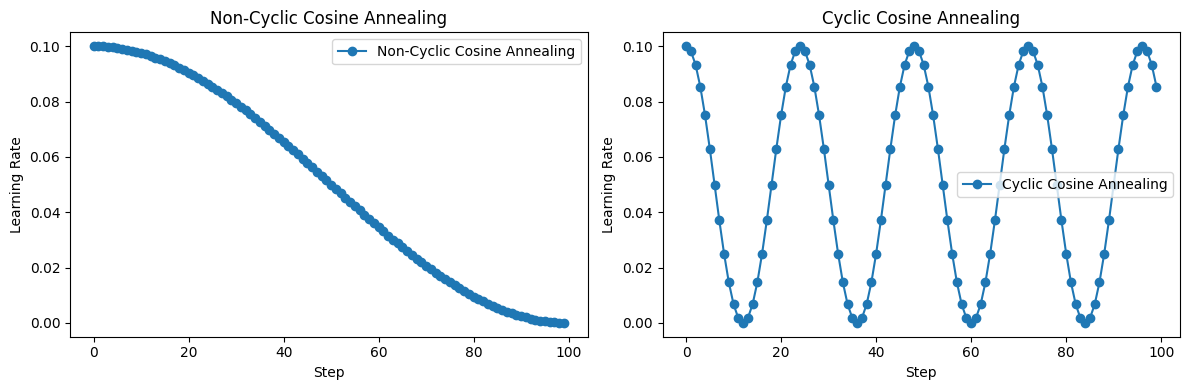

In [40]:
from __future__ import annotations

from typing import Any, List

import matplotlib.pyplot as plt
import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR, _LRScheduler

def get_learning_rates(optimizer: Optimizer, scheduler: _LRScheduler, steps: int) -> List[float]:
    lrs = []
    for _ in range(steps):
        lrs.append(optimizer.param_groups[0]["lr"])
        optimizer.step()
        scheduler.step()
    return lrs

def plot_learning_rates(
    lrs: List[float], title: str, marker: str = "o", ax: plt.Axes | None = None, **kwargs: Any
) -> None:
    ax = ax or plt.gca()

    ax.plot(lrs, label=title, marker=marker, **kwargs)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Learning Rate")
    ax.legend()

def main() -> None:
    initial_lr = 0.1
    eta_min = 0
    steps = 100
    model = torch.nn.Linear(2, 1)

    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)
    scheduler_non_cyclic = CosineAnnealingLR(optimizer, T_max=steps, eta_min=eta_min)
    lrs_non_cyclic = get_learning_rates(optimizer, scheduler_non_cyclic, steps)

    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)
    scheduler_cyclic = CosineAnnealingLR(optimizer, T_max=steps // 8, eta_min=eta_min)
    lrs_cyclic = get_learning_rates(optimizer, scheduler_cyclic, steps)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_learning_rates(lrs_non_cyclic, 'Non-Cyclic Cosine Annealing', ax=axes[0])
    plot_learning_rates(lrs_cyclic, 'Cyclic Cosine Annealing', ax=axes[1])

    plt.tight_layout()
    plt.show()

main()

#### Warmup

Our motivation would have ended here, but in practice, we often see that the
cosine annealing scheduler is often combined with a warmup phase. In
{numref}`why-cosine-warmup-loss-plot`, we can see that the loss curve is
relatively smooth and converges way better than the ones without warmup.

```{figure} ../../playbook/assets/warmup_loss_plot_uvadlc.svg
---
name: why-cosine-warmup-loss-plot-duplicate
---

Training loss v.s. # of iterations of Transformers on the De-En IWSLT’14 dataset.

**Image Credit:**
[ON THE VARIANCE OF THE ADAPTIVE LEARNING RATE AND BEYOND](https://arxiv.org/pdf/1908.03265.pdf)
```

It might be worth having some intuition on why warmup works so well in practice,
and in particular, in language models like
[Transformers](https://arxiv.org/abs/1706.03762).

Firstly, the [RAdam](https://arxiv.org/pdf/1908.03265.pdf) paper suggests warmup
works as a variance reduction technique, which overcomes the problem of
[bias correction factors](https://stats.stackexchange.com/questions/232741/why-is-it-important-to-include-a-bias-correction-term-for-the-adam-optimizer-for)
in optimizers like Adam, where having these bias correction factors would lead
to larger variance in the adaptive learning rate during the **initial** training
iterations {cite}`lippe2023uvadlc`. More concretely, Adam estimates the first
and second moments of the gradient to change the learning rate of each
individual parameter (hence adaptive) and having high variance between adaptive
learning rates may de-stablize the training. If we don't want to swap out Adam,
then this calls for a warmup phase to stabilize the learning rate and reduce the
variance in the early stages of training.

Secondly, language models like Transformers use iteratively applied Layer
Normalization across layers can lead to very high gradients during the first
iterations, which can be solved by using
[Pre-Layer Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf)
(similar to Pre-Activation ResNet), which applies normalization before the
layer's main operations, contributing to gradient stabilization and reducing the
necessity for a warm-up phase, or replacing Layer Normalization by other
techniques
([Adaptive Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf),
[Power Normalization](https://arxiv.org/abs/2003.07845))
{cite}`lippe2023uvadlc`.

However, even though there are solutions to the problem, certain setups still
use the Adam optimizer, and therefore warmup is still a simple and effective
technique to stabilize the learning rate in the early stages of training -
solving the afforementioned problems (i.e. stabilize the bias correction
factors, moving averages of gradients and squared gradients).

To this end, we end our discussion on the motivation behind 1) using cosine
annealing schedulers and 2) using warmup phases, often coupled with cosine
annealing schedulers. In what follows, we will provide a more formal definition
of the cosine annealing scheduler with warmup, and provide a running example to
illustrate the behavior of the scheduler.

#### Definition

The `CosineAnnealingWithWarmupScheduler` decays the learning rate $\eta$
according to the decreasing part of a cosine curve, with an initial warmup
$t_{\text{warmup}}$.

This scheduler modulates $\eta$ within defined upper and lower bounds over a
predetermined interval, employing a cosine function. The formula for cosine
annealing reflects the shape of a half-cosine wave, which decreases from a
maximum value to a minimum and then increases back to the maximum. This cycle
can repeat multiple times over the training process, depending on how the
scheduler is configured. Although this approach suggests cyclic adjustments
(oscillations) within the training duration, for simplicity's sake, our specific
implementation, inspired by
[**MosaicML's Composer's CosineAnnealingWithWarmupScheduler**](https://docs.mosaicml.com/projects/composer/en/latest/api_reference/generated/composer.optim.CosineAnnealingWithWarmupScheduler.html),
explicitly excludes considerations for such cycles/oscillations.

```{prf:definition} Cosine Annealing With Warmup
:label: why-do-we-use-warmup-cosine-scheduler-definition-duplicate

The `CosineAnnealingWithWarmupScheduler` modulates the **learning rate** $\eta$
according to a **two-phase** process: a **_warmup_** phase followed by a
**cosine annealing** phase. The learning rate _multiplier_[^lr-multiplier]
$\alpha_{t}$ at any given time (step) $t$ is given by:

$$
\begin{equation}
\alpha_{t} = \begin{cases}
    \frac{t}{t_{\text{warmup}}}, & \text{if } t < t_{\text{warmup}} \\
    \alpha_f + (1 - \alpha_f) \times \frac{1}{2} \left[1 + \cos(\pi \times \tau_w) \right], & \text{otherwise}
\end{cases}
\end{equation}
$$

where we denote:

-   $t$ represents the **current** training step or epoch.
-   $\eta_{\max}$ as the **maximum** learning rate reached during training, and
    often is the **initial** learning rate given into an optimizer.
-   $t_{\text{warmup}}$ denotes the duration of the warmup period, in terms of
    the number of steps or epochs, during which the learning rate **linearly**
    increases to the maximum learning rate $\eta_{\max}$.
-   $t_{\max}$ as the **maximum** number of training steps, or maximum number of
    iterations in an epoch (see
    [here](https://github.com/skorch-dev/skorch/issues/610)).
-   $\tau_w = \frac{t - t_{\text{warmup}}}{t_{\max}}$, the fraction of
    post-warmup time elapsed,
-   $\alpha_f$ is a _scaling_ factor that determines the **final** learning rate
    multiplier to decay to (a value between $0$ and $1$), and this is a _fixed_
    value. For example, if $\alpha_f = 0.1$ and the initial learning rate is
    $\eta_{\max} = 3e-4$, then the final learning rate will be
    $\eta_{\min} = 3e-4 \times 0.1 = 3e-5$.

The actual learning rate $\eta_{t}$ at time (step) $t$ is then computed as:

$$
\begin{equation}
    \eta_{t} = \alpha_{t} \times \eta_{\max}
\end{equation}
$$

where we emphasize again that $\eta_{\max}$ is the **maximum** learning rate
reached during training.
```

```{admonition} A Word on Oscillations
:class: note

Note that if you set $t_{\max}$ to the total number of training steps that is
needed for the entire dataset $\mathcal{S}$, the scheduler _will only decay_ the
learning rate after the warmup phase and not oscillate further. This
configuration means that after completing the linear increase during the warmup,
the learning rate will decrease following a cosine curve until it reaches the
final learning rate determined by $\alpha_f$.

-   **Single Cycle (No Oscillation)**: If $t_{\max}$ is set to cover exactly one
    half-cycle of the cosine function from the end of the warmup phase to the
    conclusion of training, the learning rate will monotonically decrease from
    its maximum value (at the end of warmup) to its minimum value (as determined
    by $\alpha_f$) without oscillating. This is because the scheduler's active
    period only spans a single descent phase of the cosine wave.
-   **Multiple Cycles (Oscillation)**: If $t_{\max}$ is set to allow for a
    longer duration than what is needed for a single half-cycle descent, the
    cosine annealing function can complete its initial descent and then begin to
    ascend as part of a new cycle. This leads to oscillations in the learning
    rate—after decreasing, it will start to increase again, potentially multiple
    times, depending on the total number of cycles fitted within $t_{\max}$.
    This is where the term "oscillation" comes into play; it describes the
    periodic increase and decrease in the learning rate according to the cosine
    function over multiple cycles.

True oscillation, where the learning rate decreases and then increases within a
training regime, typically requires either a restart mechanism (as seen in
[Cosine Annealing with Warm Restarts](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html))
or an explicit multi-cycle configuration. A standard cosine annealing scheduler,
especially with a warmup phase, generally only supports a monotonic decrease
within a single cycle, unless it is specifically designed to handle restarts or
multiple cycles.
```


#### Implementation

In [41]:
from __future__ import annotations

import math
from functools import partial

from torch.optim.lr_scheduler import LambdaLR
from torch.optim.optimizer import Optimizer

def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, alpha_f: float
) -> float:
    """
    Helper function for calculating the learning rate using cosine annealing
    with warmup.

    Parameters
    ----------
    current_step: int
        The current step in the training process.
    num_warmup_steps: int
        The number of steps for the warmup phase.
    num_training_steps: int
        The total number of training steps.
    alpha_f: float
        The minimum learning rate at the end of the schedule.

    Returns
    -------
    float
        The calculated learning rate.
    """

    if current_step < num_warmup_steps:
        alpha = current_step / max(1, num_warmup_steps)
    else:
        tau_w = (current_step - num_warmup_steps) / num_training_steps
        tau_w = min(1.0, tau_w)
        alpha = alpha_f + (1 - alpha_f) * (1 + math.cos(math.pi * tau_w)) / 2
    return alpha


def get_cosine_annealing_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    alpha_f: float = 0.1,
    last_epoch: int = -1,
    verbose: bool = False,
) -> LambdaLR:
    """
    Create a schedule with a learning rate that decreases following the values
    of the cosine function between the initial lr set in the optimizer to 0,
    after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Parameters
    ----------
    optimizer: `~torch.optim.Optimizer`
        The optimizer for which to schedule the learning rate.
    num_warmup_steps: int
        The number of steps for the warmup phase.
    num_training_steps: int
        The total number of training steps.
    alpha_f: float
        The minimum learning rate at the end of the schedule, by default 0.1.
    last_epoch: int
        The index of the last epoch when resuming training, by default -1.
    verbose: bool
        Whether to print the learning rate at every update, by default False.

    Returns
    -------
    `torch.optim.lr_scheduler.LambdaLR`
        The scheduler with the appropriate schedule.

    Examples
    --------
    >>> from torch import nn
    >>> from torch.optim import Adam
    >>> dummy_model = nn.Linear(1, 1)
    >>> optimizer = Adam(dummy_model.parameters(), lr=3e-4)
    >>> scheduler = get_cosine_annealing_with_warmup(optimizer, num_warmup_steps=5, num_training_steps=10, alpha_f=0.5)
    >>> assert isinstance(scheduler, LambdaLR)
    """

    lr_lambda = partial(
        _get_cosine_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
        alpha_f=alpha_f,
    )
    return LambdaLR(optimizer, lr_lambda, last_epoch, verbose)


In [42]:
num_warmup_steps = 3 * len(train_loader)
num_training_steps = composer.trainer.max_epochs * (len(train_dataset) // composer.data.train_loader["batch_size"])
alpha_f = 0.5

In [43]:
scheduler = get_cosine_annealing_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, alpha_f=alpha_f)

### Criterion

The Cross Entropy Loss function calculates the difference between two
probability distributions - the predicted probability distribution output by the
model (logits) and the actual distribution (target labels). It's primarily used
in classification tasks involving $C$ classes.

-   $\mathcal{B}$ : Denotes batch size,
-   $K$ : The number of additional dimensions beyond batch and class,
    representing spatial or other feature dimensions in the input tensor,
-   $N=\mathcal{B} \times d_1 \times \ldots \times d_K$ : Total count of
    individual elements across all dimensions, including batch and spatial
    dimensions. This value adjusts as per the dimensional complexity:
-   For $K=0, N=\mathcal{B}$,
-   For $K=1, N=\mathcal{B} \times d_1$,
-   For $K>1, N$ scales accordingly.
-   $C$ : The total number of classification categories,
-   $x$ : Represents the input logits tensor,
-   $y$ : Denotes the target tensor,
-   $w$ : An optional tensor assigning weights to each class,
-   $\mathcal{L}$ : Symbolizes the aggregate loss prior to any reduction,
-   $l_b$ : The loss corresponding to the $b$ th element within the batch,
    ranging over $b=1$ to $\mathcal{B}$.

#### Inputs and Targets

-   **Inputs (Logits)**: The function expects unnormalized logits for each class
    per input. These logits do not necessarily need to be positive values nor
    sum to 1. The shape of the input tensor can be:

    -   For unbatched input: $(C)$,
    -   For batched input: $(\mathcal{B}, C)$,
    -   For $K$-dimensional input: $(\mathcal{B}, C, d_1, d_2, \ldots, d_K)$,
        suitable for tasks like pixel-wise classification in images where
        $K \geq 1$.

-   **Targets**: When configuring the targets for the Cross Entropy Loss
    function, their expected shapes vary based on the nature of the targets
    (class indices vs. probabilities) and the dimensionality of the input:

    -   **For Class Indices as Targets**:

        -   Unbatched input: The shape should be a scalar representing a single
            class index in $[0, C)$.
        -   Batched input: The shape should be $(\mathcal{B},)$, where each
            element is a class index for the corresponding input in the batch.
        -   $K$-dimensional input: The shape should be
            $(\mathcal{B}, d_1, d_2, \ldots, d_K)$ for the $K$-dimensional case,
            with each element representing a class index for the corresponding
            spatial location.

    -   **For Probabilities as Targets** (applicable in advanced scenarios like
        label smoothing or multi-label classification):
        -   The shape of the targets must match the shape of the input logits
            tensor: $(\mathcal{B}, C)$ for batched input or
            $(\mathcal{B}, C,
            d_1, d_2, \ldots, d_K)$ for
            $K$-dimensional input. Each element in this tensor should be a
            probability corresponding to the likelihood of the class, with
            values in $[0, 1]$.

#### Loss Computation

1. **For Class Indices as Targets**:

The loss for each element $n$, accurately spanning across all considered
dimensions, is calculated as:

$$
\ell(x, y) = \mathcal{L} = \{l_1, \ldots, l_{N}\}^{\top}, \quad l_n = -w_{y_n} \cdot \log \left( \frac{\exp(x_{n, y_n})}{\sum_{c=1}^{C} \exp(x_{n, c})} \right) \cdot \mathbb{1}\{y_n \neq \text{ignore_index}\}
$$

Here, $N$ correctly reflects the aggregate count of elements when considering
$\mathcal{B}$ and the $K$-dimensional context. Consequently, if $K=0$, $N$
reduces to $\mathcal{B}$.

2. **For Probabilities as Targets**:

In cases where the targets are probabilities, the calculation over each element
$n$, aligning with $N$'s definition, should be:

$$
\ell(x, y) = \mathcal{L} = \{l_1, \ldots, l_{N}\}^{\top}, \quad l_n = -\sum_{c=1}^{C} w_c \cdot y_{n, c} \cdot \log \left( \frac{\exp(x_{n, c})}{\sum_{i=1}^{C} \exp(x_{n, i})} \right)
$$

#### Reduction

-   **No Reduction** (`reduction='none'`):

    When the reduction is set to 'none', the loss computation preserves the
    original dimensionality of the input, effectively returning a tensor that
    maps directly to each input element's loss. This tensor has the shape
    $(\mathcal{B}, d_1, \ldots, d_K)$, where each element $l_{n}$ within this
    tensor represents the computed loss for the corresponding input element
    across all dimensions, including the batch and any $K$-dimensional space:

    $$
    \mathcal{L} = \{l_1, \ldots, l_N\}
    $$

    This preserves the granularity of loss across the dataset, allowing for
    detailed analysis or custom reduction post hoc.

-   **Mean Reduction** (`reduction='mean'`):

    For the 'mean' reduction, the losses across all elements are averaged to
    yield a single scalar value. This operation accounts for the total count of
    elements ($N$), including those spanning batch and additional dimensions,
    and is not merely an average over the batch size $\mathcal{B}$, but over all
    $N$ elements:

    $$
    \mathcal{L}_{mean} = \frac{1}{N} \sum_{n=1}^{N} l_n
    $$

    Here, traditionally we think of $N$ as just the number of elements in the
    batch, but in the implementation, it spans all elements across the batch and
    $K$-dimensional spaces.

-   **Sum Reduction** (`reduction='sum'`):

    With 'sum' reduction, the losses for all elements are aggregated into a
    single scalar through summation, without averaging. This sums the losses
    across all elements, including those across the batch and $K$-dimensional
    spaces:

    $$
    \mathcal{L}_{sum} = \sum_{n=1}^{N} l_n
    $$

    This scalar represents the total loss accumulated across the entire input
    set, providing a measure of overall loss magnitude without
    normalization by the number of elements.

#### Simple Binary Classification Example

-   `nn.CrossEntropyLoss` in PyTorch expects the input logits to be of shape
    `[N, C, d1, d2, ..., dK]` (where `N` is the batch size, `C` is the number of
    classes, and `d1` to `dK` are optional additional dimensions) and the target
    to be of shape `[N, d1, d2, ..., dK]`.
-   Let's look a simplified example in image classification. The target is a
    single integer representing the class label, and the input logits are a
    vector of length `C` (the number of classes).
- More concretely, in the below example, we have $\mathcal{B} = 4$ (batch size),
  $C = 2$ (number of classes), $K = 0$ (no additional dimensions), and $N = 4$
    (total number of elements across all dimensions).

    - Our inputs (logits) are of shape $(\mathcal{B}, C) = (4, 2)$.
    - Our targets are of shape $(\mathcal{B}) = (4)$.

In [44]:
rng = torch.Generator().manual_seed(composer.global_.seed)
criterion = nn.CrossEntropyLoss(reduction="mean")
B, C = 4, 2
targets = torch.tensor([1, 0, 0, 0]) # indicating sample 1 is class 1 and sample 2 is class 0
logits  = torch.tensor([[0.1, 0.9], [0.9, 0.1], [0.8, 0.2], [0.3, 0.7]])
assert logits.size() == (B, C)
loss   = criterion(logits, targets)
pprint(loss)

tensor(0.5232)

#### GPT Example

First we set up the criterion for the model. We use the `nn.CrossEntropyLoss`
criterion, which is commonly used for classification tasks. 

In [48]:
criterion = nn.CrossEntropyLoss(reduction="mean", ignore_index=vocabulary.token_to_index[vocabulary.PAD])

In scenarios involving classification tasks, targets and inputs (logits) usually
align in a straightforward manner where each target is a single integer that
signifies the class label, and the corresponding input logits form a vector of
length $C$ (the number of classes).

However, complexity arises when dealing with sequences, such as in decoder
outputs, this is because we are predicting a sequence of class labels for each
token in the sequence. So if a sequence $\mathbf{x}$ has $10$ tokens
$x_1, x_2, \ldots, x_{10}$, the target is a sequence of class labels
$y_1, y_2, \ldots, y_{10}$. While the target shape is still $(\mathcal{B}, T)$,
and for each sample, you can think of it as $10$ samples embedded within, each
with a single class label corresponding to the token at that step. Consequently,
the logits shape becomes $(\mathcal{B}, T, \mathcal{V})$, where $\mathcal{V}$
aligns with $\mathcal{C}$, the number of classes. In other words, this
counter-intuitive structure can be easily reduced to our normal classification
problem if we remove the batch dimension to have $(T, )$ and $(T, \mathcal{V})$
respectively for the target and logits - in which case we can treat $T$ as the
batch size $\mathcal{B}$ and proceed as usual. To this end, if we want to
introduce the batch dimension back, then a simple idea is to flatten the target
and logits to $(\mathcal{B} \times T, )$ and
$(\mathcal{B} \times T, \mathcal{V})$ respectively. This way, say we have a
batch size of $2$ and a sequence length of $3$, we can easily think of it as $6$
samples in total, each with a single class label. Why this idea isn't obvious to
me at first is because not having the fundamentals from earlier models such as
RNNs and LSTMs.

Let's consider the example below, with batch size $\mathcal{B} = 2$, sequence length $T = 10$, and number of classes $V = 18$.

In [63]:
rng = torch.Generator().manual_seed(composer.global_.seed)
input_tokens, targets, _, _ = next(iter(train_loader))

B, T, V = 2, 10, 18

# get only first two samples
input_tokens = input_tokens[0:B, :]
targets = targets[0:B, :]
assert input_tokens.size() == (B, T)
assert targets.size() == (B, T)

# get logits
logits = model(input_tokens)
assert logits.size() == (B, T, V)  # 2, 10, 18

In [62]:
logits.view(-1, logits.size(-1)).size(), targets.view(-1).size()

(torch.Size([20, 18]), torch.Size([20]))

In [64]:
logits_flattened = logits.view(-1, logits.size(-1))
targets_flattened = targets.view(-1)

assert logits_flattened.size() == (B * T, V)

loss = criterion(logits_flattened, targets_flattened)
pprint(loss)

tensor(2.8306, grad_fn=<NllLossBackward0>)

The second way we will use is essentially the same
as the first way, but more implicit.

In [67]:
logits.permute(0, 2, 1).contiguous().shape

torch.Size([2, 18, 10])

We first permute the logits tensor to have the shape
$(\mathcal{B} \times \mathcal{V}, T)$, why so? Because recall our earlier
definition in PyTorch's `nn.CrossEntropyLoss` where the input logits should be
of shape `[B, C, d1, d2, ..., dK]` (where `B` is the batch size, `C` is the
number of classes, and `d1` to `dK` are optional additional dimensions) and the
target to be of shape `[B, d1, d2, ..., dK]`. In our case, we have
$\mathcal{B} = 2$ (batch size), $C = 18$ (number of classes), $K = 1$
(additional dimension), but however we are in the wrong order of dimension
because PyTorch expects the first dimension to be of batch size, which is fine,
but the second dimension must be the class dimension, which in our case is not
because our second dimension is the sequence length $T$. So we swap the second
and third dimension to have the shape $(\mathcal{B}, \mathcal{V}, T)$, and then
PyTorch's `nn.CrossEntropyLoss` would then reshape the logits to
$(\mathcal{B} \times T, \mathcal{V})$ and the targets to
$(\mathcal{B} \times T, )$ - coinciding with our earlier discussion.


In [65]:
loss = criterion(logits.permute(0, 2, 1).contiguous(), targets.contiguous())
pprint(loss) # same

tensor(2.8306, grad_fn=<NllLoss2DBackward0>)

In a GPT-like model, each token in the sequence is used to predict the next
token. The model takes a sequence of tokens and produces a new sequence of the
same length where each new token is predicted based on all the preceding tokens
in the input sequence. The loss is then computed between the predicted sequence
and the target sequence.

Let's take a closer look at an example:

-   The original tensor: `[15, 9, 0, 10, 3, 8, 13, 1, 2, 8, 14]` which
    corresponds to `<BOS>90+38=128<EOS>`
-   Input tensor: `[15, 9, 0, 10, 3, 8, 13, 1, 2, 8]`, which corresponds to
    `<BOS>90+38=128` without `EOS`
-   Target tensor: `[9, 0, 10, 3, 8, 13, 1, 2, 8, 14]`
    `[16, 16, 16, 16, 16, 16, 1, 2, 8, 14]`

During training:

1. **First Timestep**: The model takes `[15]` (or `[<BOS>]` if 15 is your BOS
   token) and tries to predict the next token. Ideally, it should predict `9`.
   But here, your target sequence starts with masked tokens (`16`, if 16 is your
   masking token). So the loss is computed between the predicted token and the
   masked token `16`. But since `CrossEntropyLoss` has an `ignore_index` (now
   you know what they are right!), you can set it to say `16` or (default `-1`
   but you would need to change padding number) and tell the model that whenever
   the ground truth is `16`, the loss is zeroed out so it is not counted? This
   allows the model to focus on learning from the relevant parts of the sequence
   while ignoring the masked portions.

2. **Second Timestep**: The model takes `[15, 9]` and predicts the next token,
   which should be `0`. Again, the target is a masked token `16`.

3. **...**

4. **Eighth Timestep**: The model takes `[15, 9, 0, 10, 3, 8, 13]` (which is
   `90+38=`) and predicts the next token. Now the target is `1`, so the loss is
   computed between the predicted token and `1`. There is no mask anymore here,
   so the loss will be computed.
5. **Ninth Timestep**: The model takes `[15, 9, 0, 10, 3, 8, 13, 1]` (which is
   `90+38=1`) and predicts the next token. Now the target is `2`, so the loss is
   computed between the predicted token and `2`.
    1. Here's an important thing for beginners (me), In a typical GPT-like
       architecture used for sequence-to-sequence tasks like this one, the model
       doesn't use its own predictions as input during training. Instead, it
       uses the original, ground-truth input sequence. This is known as "teacher
       forcing." In teacher forcing, even if the model predicts a wrong token at
       some timestep, it doesn't affect the input sequence for subsequent
       timesteps. The model continues to get the original input sequence for the
       entire training epoch.
    2. So if model predicts a `3` during the eighth timestep, where the ground
       trut is `1`, the model would simply incur a higher loss for that
       prediction. However, the input for the ninth timestep would still be the
       ground truth sequence up to that point, regardless of what the model
       predicted at the eighth timestep.
    3. But it is noted that this behaviour is still autoregressive.
6. **Tenth**: The model takes `[15, 9, 0, 10, 3, 8, 13, 1, 2]` and predicts the
   next token which is `8`.
7. **Last**: The model takes `[15, 9, 0, 10, 3, 8, 13, 1, 2, 8]` and predicts
   the next token which is `14` the `EOS`.
    1. The reason you need to predict `EOS` is simple intuitively, consider the
       case where there's no need for `EOS`, then the model will not know when
       to stop.

This goes on until the entire sequence is processed. Note that the model never
actually "sees" the target tokens during the prediction. It is solely relying on
the tokens that came before the current token in the input sequence. After the
model makes its prediction, then the predicted tokens are compared to the target
tokens to compute the loss, which is then backpropagated to update the model
weights.

#### A Smaller Example for Illustration

The above example has too big of a dimension, let's
scale down $T=10$ to $T=3$ and $V=18$ to $V=4$.

In [68]:
# fmt: off
rng        = torch.Generator().manual_seed(composer.global_.seed)

B, T, V    = 2, 3, 4                                                   # Assuming we have B = batch size, T = sequence length, V = vocab size

logits     = torch.randn(B, T, V, generator=rng)                       # logits from the head
targets    = torch.randint(low=0, high=V, size=(B, T), generator=rng)  # targets are the labels
# fmt: on

pprint(logits)
pprint(targets)
pprint(logits[0]) # logits for the first sequence [T=3, V=4]
pprint(targets[0]) # target for the first sequence [T=3]

tensor([[[ 1.9269,  1.4873,  0.9007, -2.1055],
│   │    [ 0.6784, -1.2345, -0.0431, -1.6047],
│   │    [ 0.3559, -0.6866, -0.4934,  0.2415]],
│   │   
│   │   [[-1.1109,  0.0915, -2.3169, -0.2168],
│   │    [-0.3097, -0.3957,  0.8034, -0.6216],
│   │    [-0.5920, -0.0631, -0.8286,  0.3309]]])

tensor([[2, 2, 1],
│   │   [3, 3, 3]])

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
│   │   [ 0.6784, -1.2345, -0.0431, -1.6047],
│   │   [ 0.3559, -0.6866, -0.4934,  0.2415]])

tensor([2, 2, 1])

We establish some conceptual understanding first:

-   Each sample in the batch has the following characteristics:
    -   Denote `target` and `logit` as the target and logits for a particular
        sample in the batch.
    -   The `target` is of shape `[T] = [3]` and each element is the class/vocab
        label for each token in the sequence.
    -   The `logit` is of shape `[T, V] = [3, 4]` and each row is the logits for
        each token in the sequence.
    -   Therefore, we want to compare each row in `logit` with each element in
        `target` to compute the loss.
    -   We can think of each row in `logit` as the prediction for each token in
        the sequence, and each element in `target` as the ground truth for each
        token in the sequence.
    -   Intuitively this means that within each sample, there are many
        "sub-samples" where each sub-sample is a token in the sequence. If you
        can visualize this, then there should be no confusion.
-   In code, we can do so with the following manner:
    -   Calculate loss for each token in each sample individually and then sum
        them up.
    -   Reduction by mean will mean we need to divide our `total_loss` by the
        total number of samples in the batch. But remember that even though
        technically we have 2 samples in the batch, we are actually treating
        each token in each sample as a sub-sample, so the total samples is
        `B * T` where `B` is the batch size and `T` is the sequence length.


In [69]:
criterion  = nn.CrossEntropyLoss(reduction="mean")

total_loss = 0
for b in range(B):
    for t in range(T):
        logit      = logits[b, t].unsqueeze(0)
        target     = targets[b, t].unsqueeze(0)
        total_loss += criterion(logit, target)

pprint(total_loss)
total_loss  = total_loss / (B * T)
pprint(total_loss)

tensor(9.0105)

tensor(1.5017)

In PyTorch however, if you have a logits tensor of shape `[B, S, V]`, you need
to permute it to `[B, V, S]` to align with the format that `CrossEntropyLoss`
wants, so that `V` (vocab size) is treated as `C` (number of classes), and `S`
(sequence length) is treated as one of the additional dimensions
`d1, d2, ..., dK`.

But all in all, if you understood the previous loop to calculate the loss for
each token in each sample individually and then sum them up, then dividing to
fulfill reduction of mean, then you should be fine.


#### Masking and Ignore Index

In [70]:
# fmt: off
rng        = torch.Generator().manual_seed(composer.global_.seed)

B, T, V    = 2, 3, 4                                                   # Assuming we have B = batch size, L = sequence length, V = vocab size

logits     = torch.randn(B, T, V, generator=rng)                       # logits from the head
targets    = torch.randint(low=0, high=V, size=(B, T), generator=rng)  # targets are the labels
# fmt: on

pprint(logits)
pprint(targets)
pprint(logits[0]) # logits for the first sequence [L=10, V=18]
pprint(targets[0]) # target for the first sequence [L=10]

tensor([[[ 1.9269,  1.4873,  0.9007, -2.1055],
│   │    [ 0.6784, -1.2345, -0.0431, -1.6047],
│   │    [ 0.3559, -0.6866, -0.4934,  0.2415]],
│   │   
│   │   [[-1.1109,  0.0915, -2.3169, -0.2168],
│   │    [-0.3097, -0.3957,  0.8034, -0.6216],
│   │    [-0.5920, -0.0631, -0.8286,  0.3309]]])

tensor([[2, 2, 1],
│   │   [3, 3, 3]])

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
│   │   [ 0.6784, -1.2345, -0.0431, -1.6047],
│   │   [ 0.3559, -0.6866, -0.4934,  0.2415]])

tensor([2, 2, 1])

In [71]:
targets[:, 0] = -123
PAD_ = -123

criterion  = nn.CrossEntropyLoss(reduction="mean", ignore_index=PAD_)

NON_IGNORE_COUNT = 0

total_loss = 0
for b in range(B):
    for t in range(T):
        logit      = logits[b, t].unsqueeze(0)
        target     = targets[b, t].unsqueeze(0)
        if target == torch.tensor([PAD_]):
            continue
        total_loss += criterion(logit, target)
        NON_IGNORE_COUNT += 1

pprint(total_loss)
total_loss  = total_loss / NON_IGNORE_COUNT
pprint(total_loss)

tensor(6.2188)

tensor(1.5547)

NOTE: `NON_IGNORE_COUNT` is used instead of `BxT`, why? Cause we are averaging
over all non-ignored guys!


In [72]:
# Permute logits to shape [B, V, S]
logits_permuted = logits.permute(0, 2, 1)

# Instantiate the CrossEntropyLoss
# By default, it reduces by averaging the losses over each observation in the input
criterion  = nn.CrossEntropyLoss(reduction="mean", ignore_index=PAD_)

loss = criterion(logits_permuted, targets)
pprint(loss)

tensor(1.5547)

In [ ]:
# Permute logits to shape [B, V, S]
logits_permuted = logits.permute(0, 2, 1)

# Instantiate the CrossEntropyLoss
# By default, it reduces by averaging the losses over each observation in the input
criterion = nn.CrossEntropyLoss(reduction="mean")

loss = criterion(logits_permuted, targets)
pprint(loss)

#### Initializing Criterion With Composer

In [ ]:
from omnivault.transformer.config.criterion import CRITERION_REGISTRY

criterion_config_cls = CRITERION_REGISTRY[cfg.criterion.name]
criterion_pydantic_config = criterion_config_cls(**cfg.criterion)

criterion = criterion_pydantic_config.create_instance()
assert criterion.ignore_index == vocabulary.token_to_index[vocabulary.PAD]

pprint(criterion.ignore_index)
pprint(criterion.reduction)

## State

In [ ]:
from omnivault.transformer.core.state import State

state = State(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    vocabulary=vocabulary,
    tokenizer=tokenizer,
)
state.pretty_print()

## Trainer

In [ ]:
trainer = Trainer(
    state=state,
    composer=composer,
    logger=LOGGER,
    device=composer.trainer.device,  # type: ignore[arg-type]
)
trainer.remove_callback(event=TrainerEvent.ON_VALID_EPOCH_END.value, callback=save_state)

# trainer.add_callback(
#     TrainerEvent.ON_VALID_EPOCH_END.value,
#     lambda trainer: evaluate_and_generate_on_valid_epoch_end(trainer, num_batches_to_eval=None),
# )
# _trained_state = trainer.fit(train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)
_trained_state.pretty_print()
history = _trained_state.history

In [ ]:
batch = next(iter(train_loader))
pprint(batch)

inputs, targets, target_padding_masks, future_masks = batch


# Step 2: Pass the sample through the model
trained_model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    # Assuming your model and sample require specific formatting, adjust as necessary
    logits = model(inputs, target_padding_masks=target_padding_masks, future_masks=future_masks)

In [ ]:
last_decoder_block = trained_model.decoder_blocks[-1] # take last decoder block? more feature?
# pprint(last_decoder_block)

masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
pprint(masked_self_attention_mha)

context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights
pprint(attention_weights.shape)
# but has H=4 heads so do we take 1 head and check the heatmap?
# torch.Size([208, 4, 10, 10])

last_batch_last_sample_first_head_attention_weights = attention_weights[-1, 0:1, :, :].squeeze(0)
pprint(last_batch_last_sample_first_head_attention_weights.shape)


the xy axis is keys and queries, which is correct `Q @ K.T`

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing setup
last_decoder_block = trained_model.decoder_blocks[-1]
masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights

# Number of heads
num_heads = attention_weights.size(1)

# Labels for each character in the sequence, including BOS
labels = ['<BOS>'] + list('59+14=073')

# Loop over each head and plot its heatmap
for head in range(num_heads):
    plt.figure(figsize=(10, 10))

    # Extract attention weights for the last sample in the last batch for this head
    attention_matrix = attention_weights[-1, head, :, :].detach().numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis', xticklabels=labels, yticklabels=labels)
    plt.title(f"Attention Weights Heatmap for '<BOS>59+14=073' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()


```
x -> tensor([[15,  9,  8, 10,  3,  5, 13]])
future_mask -> 7x7
tensor([[ True, False, False, False, False, False, False],
│   │   [ True,  True, False, False, False, False, False],
│   │   [ True,  True,  True, False, False, False, False],
│   │   [ True,  True,  True,  True, False, False, False],
│   │   [ True,  True,  True,  True,  True, False, False],
│   │   [ True,  True,  True,  True,  True,  True, False],
│   │   [ True,  True,  True,  True,  True,  True,  True]])

logits--> 1x7x18 because 1 sample
tensor([[[  7.8,  -0.2,  -2.3,  -1.1,  -0.1,  -3.2,  -4.4,
          -2.4,   3.7,  -0.9,  -5.1,  -4.5,  -5.6,  -2.2,
          -0.5,  -4.2,  -2.9,  -4.9],
        [  0.3,   3.7,   0.9,   1.7,   0.4,  -4.0,  -6.0,
          -2.3,   8.5,   7.3,  -6.0,  -5.1,  -6.2,  -3.0,
         -10.9,  -3.8,  -5.3,  -5.9],
        [-10.5,  -0.4,   4.3,   2.4,  -6.3,  -8.9,  -0.1,
           8.2,   8.6,   0.4,   1.2,   0.9,   0.7,   0.6,
           6.9,   0.0,   0.4,   1.2],
        [ -2.8,   9.6,   2.0,  -6.2,  -8.2,  -2.3,   5.7,
           6.6,  -0.3,  -4.7,  -0.5,  -0.9,  -0.9,   1.2,
           2.3,  -0.4,   0.1,  -1.5],
        [ -2.9,   1.6,  -1.0,  -5.8,  -0.2,   6.2,  14.1,
           8.0,  -4.0,  -9.7,  -2.1,  -3.4,  -3.2,  -1.4,
           0.0,  -1.7,   0.0,  -3.0],
        [ -9.4,   1.7,   5.4,  -1.3,  -6.6,  -4.7,   6.7,
          10.2,   1.9,  -9.6,   0.8,   0.6,   0.7,   1.2,
          10.2,   0.4,   1.3,   1.2],
        [  0.3,  16.1,   3.2,  -4.4,  -5.7,  -2.9,  -3.7,
          -6.1,  -2.1,   4.0,  -0.4,   0.1,  -0.4,   0.0,
           0.6,  -0.6,  -1.2,  -0.7]]])

logits.argmax(dim=-1) -> 1x7
tensor([[0,  8,  8,  1,  6, 14,  1]])
```

`logits.argmax(dim=-1)` basically compress 1x7x18 to 1x7 where for each row of the
7 rows, find the index that is maximum for example, first row 7.8 is max of all
18 elements, so index 0 is returned. `tensor([[0,  8,  8,  1,  6, 14,  1]])`

There is some meaning here too, remember our input `[15, 9, 8, 10, 3, 5, 13]`
this is basically the BOS (15) up till the equal sign, then
`[ 0, 8, 8, 1, 6, 14, 1]` is basically the prediction of each token what comes
next.

1. **Input Sequence**: Your input sequence is `[15, 9, 8, 10, 3, 5, 13]`. In
   this context, `15` could be a special token like BOS (Beginning of Sentence)
   or something else depending on your encoding scheme.

2. **Output Tensor Interpretation**: The output tensor
   `tensor([[ 0, 8, 8, 1, 6, 14, 1]])` represents the model's sequential
   predictions for each step of the input:

   - The first element `0` is the prediction following the first element `15` of
     the input.
   - The second element `8` is the prediction after seeing the first two
     elements `15, 9` of the input.
   - The third element `8` is predicted after seeing `15, 9, 8`.
   - The fourth element `1` follows after `15, 9, 8, 10`.
   - The sequence continues in this manner, with each new prediction based on an
     increasingly longer prefix of the input sequence.

3. **Sequential Predictions**: This output suggests that the model is working in
   an autoregressive manner. It generates predictions one token at a time, and
   each prediction is based on the sequence of tokens it has seen up to that
   point.

4. **Specific Meanings of Output Tokens**: The actual meaning of each token in
   your output tensor (`0`, `8`, `1`, `6`, `14`, etc.) depends on your specific
   encoding and task. In a language model, these would correspond to specific
   words or characters. In a numerical context, they could represent numbers or
   operations.

In summary, the output tensor reflects the model's predictions for what comes
next in the sequence, based on the current and all previous input tokens. Each
element in the output is the model's guess for the next token, considering the
sequence of tokens it has seen up to that point.

> Then we move on to the concat operation:


- In our model, after processing the input `[15, 9, 8, 10, 3, 5, 13]`, it
  predicts the next token to be `1`. This prediction is based on the entire
  sequence seen so far.

- The process of extending the input sequence with this new token (`1`) and then
  feeding this extended sequence back into the model for further predictions is
  indeed an example of greedy decoding. The model is iteratively building a
  longer sequence, one token at a time, always choosing the most likely next
  token at each step.

- This process would continue until a stopping condition is met, which might be
  the prediction of an EOS (End of Sentence) token or reaching a maximum
  sequence length.


> for i in range(num_digits + 2):
> now you know why loop over 4 times in total if num digits is 2.
> This is because, after equal sign, we will have answer of 3 digits (xyz)
> and an EOS token, our stop condition!

Lastly: `tensor([[15,  9,  8, 10,  3,  5, 13,  1,  3,  3, 14]])` is the full predicted
after EOS is met. 


In [ ]:
config.global_config.seed = 42

In [ ]:
def construct_future_mask(seq_len: int) -> torch.BoolTensor:
    future_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1).to(torch.bool)
    future_mask = future_mask.contiguous()
    future_mask = future_mask == 0
    return torch.BoolTensor(future_mask)

def construct_padding_mask(input_sequence: torch.Tensor, pad_token_id: int) -> torch.BoolTensor:
    padding_mask = input_sequence != pad_token_id
    return torch.BoolTensor(padding_mask)

In [ ]:
@torch.no_grad()
def compute_sum(model, x) -> List[int]:
    "Function for computing the sum of two numbers."
    # x=[[15,  9,  8, 10,  3,  5, 13]]
    for _ in range(num_digits + 2):
        # pprint(x)
        pad_mask = (x != PAD).view(1, 1, 1, x.size(-1)).to(DEVICE)
        future_mask = construct_future_mask(seq_len=x.size(1))
        batch_size, seq_len = x.size()
        future_mask = future_mask.view(1, seq_len, seq_len).expand(size=(batch_size, -1, -1)).unsqueeze(1)
        #print(pad_mask.shape, future_mask.shape)
        #inputs, targets, target_padding_masks, future_masks = construct_batches(x)
        #print(target_padding_masks.shape, future_masks.shape)
        logits = model(input_tokens=x, target_padding_masks=pad_mask, future_masks=future_mask)
        pprint(logits.shape)
        time.sleep(100)
        #logits = model(inputs, target_padding_masks=target_padding_masks, future_masks=future_masks)

        last_output = logits.argmax(-1)[:, -1].view(1, 1)
        x = torch.cat((x, last_output), 1).to(DEVICE)
        # STOPPING CONDITION!
        if last_output.item() == EOS:
            break
        #return
    return x[0]


def evaluate(model, dataloader, num_batch=None):
    """
    Function for evaluation the model.

    This function take equations, and truncate them up to the equal-sign, and feed
    them to the model to get the predictions, compare them with the correct answers,
    and output the accuracy.
    """
    model.eval()
    acc, count = 0, 0
    num_wrong_to_display = 5
    for idx, batch in enumerate(dataloader):
        (
            inputs,
            targets,
            target_padding_masks,
            future_masks,
        ) = batch  # construct_batches(batch)
        for equation in inputs:
            # pprint(equation)
            # add EOS behind equation
            equation = torch.cat((equation, torch.tensor([EOS])), 0) # TODO: PLEASE DO NOT DO THIS - DO NOT MODIFY LIKE THIS.
            # fmt: off
            loc_equal_sign = equation.tolist().index(EQUAL)
            loc_EOS        = equation.tolist().index(EOS)
            input          = equation[0 : loc_equal_sign + 1].view(1, -1).to(DEVICE)
            ans            = equation[: loc_EOS + 1].tolist()
            ans_pred       = compute_sum(model, input)
            count += 1
            # fmt: on

            if ans == ans_pred.tolist():
                acc += 1
            else:
                if num_wrong_to_display > 0:
                    print(
                        f'correct equation: {decode_equation(vocab=vocab, equation=equation).replace("<PAD>","")}'
                    )
                    print(f"wrongly predicted as:        {decode_equation(vocab=vocab, equation=ans_pred)}")
                    num_wrong_to_display -= 1
        if num_batch and idx > num_batch:
            break
    return acc / count


def what_is(question: str) -> str:
    "function for computing the sum of two numbers with input in literal string format"
    pred = compute_sum(model, encode_equation(question, num_digits).view(1, -1))
    pred = decode_equation(pred)
    pred = pred[pred.index("=") + 1 :]
    return question + pred


The provided code implements a form of greedy decoding for sequence generation.
Let's break down how it aligns with the principles of greedy decoding:

1. **Greedy Decoding Principle**: Greedy decoding in sequence generation models
   involves choosing the most probable next token at each step of the sequence
   generation. This is done iteratively until a stopping condition is met (like
   reaching an EOS token or a maximum length).

2. **Implementation in Your Code**:

   - The `compute_sum` function generates a sequence by repeatedly predicting
     the next token and appending it to the input.
   - For each iteration in `compute_sum`:
     - The model (`model(x, pad_mask, future_mask)`) generates logits for the
       next token based on the current sequence (`x`).
     - `last_output = logits.argmax(-1)[:, -1].view(1, 1)` picks the most
       probable next token (the token with the highest logit value) from the
       logits. This is the essence of greedy decoding.
     - This token is then appended to the sequence:
       `x = torch.cat((x, last_output), 1)`.
   - The process continues until the model generates an EOS token, as indicated
     by `if last_output.item() == EOS: break`.

3. **Evaluation Function**:

   - The `evaluate` function further confirms this approach by feeding truncated
     sequences (up to the equal sign) from the dataloader to the `compute_sum`
     function and comparing the model's predictions to the correct answers.

4. **Characteristics of Greedy Decoding**:
   - Greedy decoding is computationally efficient and straightforward but may
     not always produce the best possible sequence. It does not reconsider past
     decisions; it always picks the most likely next token at each step without
     considering the global context of the sequence.

In summary, the provided code, especially the `compute_sum` function, implements
a typical greedy decoding approach. It iteratively generates a sequence by
choosing the most probable next token at each step, which is characteristic of
greedy decoding in sequence generation tasks.


In [ ]:
print('training set examples the model gives an incorrect result:')
# rng = torch.Generator().manual_seed(config.global_config.seed)
seed_all(1992, seed_torch=True)

train_acc = evaluate(model, train_loader, 2)
pprint(train_acc) #
# print('validataion set examples the model gives an incorrect result:')
val_acc = evaluate(model, valid_loader)
pprint(val_acc)
# print('test set examples the model gives an incorrect result:')
test_acc = evaluate(model, test_loader)
pprint(test_acc)
# result = f'''train_size: {train_size}, test_acc: {test_acc}, val_acc: {val_acc}, train_acc: {train_acc}
#                 '''
# print(result)

QUESTION:

another not so smart question of the day: For an input sequence x1,x2,...,x_L, when it forward pass all the way through the decoder model, up till before the pre-logits/head/linear layer, and assuming for simplicity that we squeeze out the first batch dimension (only 1 sample), the the shape of the pre-logits is [L, D] where L is seq len and D the hidden embedding dimension. Am I right to say that the last row of [L, D] being the last token's representation, holds info of the full context of all previous tokens.

1. This means the last token in the input sequence (the last row in [L, D]) is a function of all previous tokens, so it is not surprising why the tutorial will just use the last row/token's corresponding prediction as the next predicted token/word, given all previous tokens.

> Important to know the last token or last row of [L, D] is actually a function of all previous tokens, here it is unmasked already.
> So if confused, just remember the pre logits last row, corresponding to the last token in the input sequence, is a function of all previous tokens.
> It just means that row holds all information, context, of all previous tokens so we can say its conditioned on all previous tokens.

## Questions

### Why Masked == 0 in some?

The use of `mask == 0` in the `masked_fill` operation is a result of how the
mask is constructed. Essentially, different implementations may represent masks
differently:

1. **Boolean Masking with True/False**: In some implementations, the mask might
   be a Boolean tensor where `True` denotes the positions to mask (set to
   negative infinity) and `False` for the positions to keep. In such cases, you
   can directly use the mask in `masked_fill` as in your provided code:

    ```python
    attention_scores = attention_scores.masked_fill(mask, float("-inf"))
    ```

    Here, if `mask[i][j]` is `True`, `attention_scores[i][j]` would be set to
    `-inf`.

2. **Integer Masking with 1/0**: In other implementations, the mask might be an
   integer tensor where `1` denotes the positions to keep and `0` denotes the
   positions to mask. In such cases, you'll often find the mask is inverted
   (`mask == 0`) before using `masked_fill`:

    ```python
    attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))
    ```

    Here, if `mask[i][j]` is `0`, `attention_scores[i][j]` would be set to
    `-inf`.

The core functionality—masking certain positions in the attention scores—is the
same in both cases. The difference lies in how the mask tensor is constructed
and interpreted. So, if you find an implementation using `mask == 0`, it's
likely using an integer mask where `0` signifies positions to mask, whereas if
it's directly using `mask`, it's probably a Boolean mask where `True` signifies
positions to mask.

### what is the reason of setting the attention scores's mask indexes to negative infinity

In the attention mechanism, particularly in the Scaled Dot-Product Attention,
attention scores are computed for each query-key pair and then passed through a
softmax function to obtain attention weights. These weights are used to take a
weighted sum of the value vectors, resulting in the final output or the context
vectors. The purpose of the mask is to prevent certain tokens (like padding
tokens) from being attended to.

The reason for setting masked attention scores to negative infinity (`-inf`)
lies in the properties of the softmax function:

1. **Softmax Behavior**: The softmax function transforms its input (the
   attention scores in this case) into a probability distribution.
   Mathematically, the softmax function for a given vector $x$ is defined as:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}}
$$

2. **Impact of Negative Infinity**: When you pass negative infinity through the
   softmax function, $e^{-\infty}$ approaches zero. As a result, the masked
   positions get a near-zero weight in the attention mechanism.

$$
\text{Softmax}(-\infty) = \frac{e^{-\infty}}{\sum_{j=1}^{N} e^{x_j}} \approx 0
$$

3. **Avoiding Unwanted Attention**: The point of setting these specific
   positions to `-inf` is to ensure that when softmax is applied, these
   positions get zero attention weights. This is a way of making sure that the
   model does not attend to the positions we've masked (like padding tokens or
   future tokens in the sequence, depending on the mask).

In summary, setting the masked attention scores to `-inf` and then passing them
through a softmax effectively nullifies the contribution of the masked positions
in the resulting attention-weighted sum of the value vectors. This is a commonly
used trick to impose a certain structure (like masking out future information in
the decoder) or to handle variable-length sequences with padding.

### Why do we need both ignore index in Loss and also negative infinity mask

Using an "ignore index" in the `CrossEntropyLoss` function in PyTorch can ignore
the effect of certain tokens (like padding tokens) during the loss computation.
However, the purpose of the mask in the attention mechanism and the "ignore
index" in the loss function serve different roles in the model, and they operate
at different stages of the computational graph.

1. **Ignore Index in Loss Function**: The "ignore index" in the loss function
   ensures that the model's output at certain positions (typically corresponding
   to padding tokens) does not contribute to the loss. This happens at the very
   end of the forward pass, just before backpropagation begins.

2. **Mask in Attention Mechanism**: The mask in the attention mechanism, on the
   other hand, operates during the forward pass at the time when attention
   scores are computed. This is a more "internal" operation and ensures that
   certain positions do not contribute to the output at all, not just during the
   loss computation but actually in the intermediate representations (i.e.,
   context vectors) that the model computes.

To put it another way, even if you're ignoring certain tokens in your loss
calculation, those tokens can still influence the model's output unless they're
masked out in the attention mechanism itself.

For example, consider a decoder in a sequence-to-sequence model:

-   If you don't use a mask in the attention mechanism, future tokens could
    influence the output at the current timestep, which is not desirable.
-   Even if you use an "ignore index" in your loss function, it doesn't prevent
    the model from "cheating" by peeking at the future tokens if they are not
    masked in the attention mechanism.

So in summary, using an "ignore index" in `CrossEntropyLoss` is not a
replacement for using attention masks. Both have specific roles in the model,
and they are often used together to ensure both that the model attends to the
right tokens and that it is trained properly.

### Why sometimes unsqueeze masks?

The `unsqueeze` operation is used to add an additional dimension to the tensor.
In attention mechanisms, particularly the scaled dot-product attention used in
models like the Transformer, the masks usually need to have the same number of
dimensions as the attention logits for proper broadcasting.

For instance, let's say your source tensor (`src`) has a shape of $B \times L$
where $B$ is the batch size and $L$ is the sequence length. The attention logit
tensor resulting from the query-key dot product would then have shape
$B \times N \times L \times L$, where $N$ is the number of attention heads.

The mask needs to align with the $L \times L$ dimensions of this 4D tensor. In
order to accomplish that, you add singleton dimensions to make it compatible
with the attention logit tensor. By unsqueezing the mask tensor from
$B \times L$ to $B \times 1 \times 1 \times L$, you enable broadcasting such
that the mask effectively gets expanded to $B \times N \times L \times L$ during
the attention calculation, perfectly aligning with the attention logits.

That's why the line:

```python
self.src_mask = (src != pad).unsqueeze(-2)
```

adds a singleton dimension, converting the shape from $B \times L$ to
$B \times 1 \times 1 \times L$ for proper broadcasting during the attention
computations.

### Am i right to assume that the core idea of autoregressive model like decoder only (GPT like) is that for a given sample, there will eventually be L rows where L is the seq length, and therefore I can intuitively view it as 1 sample having L samples, since for each row, we will compute the loss. Am I right in my understanding? Do not hesistate to correct me.

Your description captures an important aspect of autoregressive models like
decoder-only Transformers (e.g., GPT). Specifically, you're talking about how
the model treats a sequence during training. Let's break down your understanding
step by step.

1. **Sequence Length**: When you mention "L rows," where "L" is the sequence
   length, you're essentially pointing out that each sequence is divided into
   "L" time steps (or tokens). Each time step becomes an input-output pair for
   training the model.

2. **One Sequence as Multiple Samples**: You're correct to intuit that a single
   sequence of length "L" can be treated like "L" samples, at least in the
   context of loss calculation. This is because, during training, the model
   computes the loss at each time step by comparing the predicted token with the
   actual next token in the sequence.

3. **Loss Computation**: The loss is often computed at each position and then
   averaged over the sequence length or summed up, depending on the specific
   loss function or training regime.

However, it's crucial to clarify that although a single sequence may contribute
"L" terms to the loss function, this is not equivalent to having "L" independent
samples. The key difference lies in the autoregressive property: the prediction
at each time step is conditioned on the preceding tokens. This introduces a
temporal dependency across the "L" positions, making them not entirely
independent samples.

In other words, while it's accurate to say that a single sequence contributes
multiple terms to the loss function, these terms are correlated because they
come from the same sequence and are generated in an autoregressive manner.

To summarize, you're mostly correct in your understanding that a single sequence
is broken down into multiple steps for the purpose of loss computation, but it's
important to remember that these steps are not independent samples due to the
autoregressive nature of the model.

### Confusion: Training versus Inference

The statement "it generates one token at a time and uses its own previously
generated tokens as context for generating subsequent tokens" is generally true
for GPT-like models during the inference stage, not during training. During
inference (or generation), the model does indeed use its own previously
generated tokens to produce the next token, since there is no ground truth
sequence to rely on. In that case, if the model makes an incorrect prediction at
a certain timestep, that incorrect token is used as part of the context for the
following timestep.

During training, however, the model typically uses the ground truth tokens for
the preceding sequence as context for predicting each next token, as described
in your example. This resembles teacher forcing, in that the ground truth,
rather than the model's own predictions, is used to guide training.

So there's no contradiction, but the behavior is context-dependent:

-   During training, the ground truth sequence is used for context.
-   During inference, the model's own previously generated tokens are used for
    context.

Both approaches are consistent with the autoregressive nature of the model: in
both cases, the token at each position is generated based on the tokens at all
previous positions. The difference lies in whether those preceding tokens come
from the ground truth (during training) or from the model's own previous outputs
(during inference).

### Training vs Inference

In an autoregressive model like a Transformer decoder, the concept of "learning
the representation of the sequence as it goes" does not refer to the model
processing one token at a time during actual forward passes. Instead, it refers
to the model's ability to generate or predict one token at a time during
inference, while training on a full sequence in a batched manner.

During training:

-   All tokens are processed in parallel for efficiency. This is possible
    because the entire sequence is known beforehand (it's the training data).
-   The "autoregressive" property is enforced by using masks in the
    self-attention mechanism. This masking ensures that the prediction for each
    token can only depend on previously generated tokens, not on future tokens
    which the model has no access to during inference. This is how the model
    learns the conditional probability distribution of each token given the
    previous tokens, despite the parallel processing of tokens.

During inference:

-   The model starts with an initial token (such as a start-of-sequence token)
    and generates the next token based on this single input.
-   Then, the model uses both the initial token and the newly generated token to
    predict the third token, and so on.
-   This process is sequential and each new token is predicted based on the
    previously generated tokens, creating a sequence one token at a time.

So, when we say that the model learns the representation of the sequence as it
goes, we mean that the model is trained to handle sequences in such a way that
it can generate them one piece at a time, respecting the causal order inherent
to the task (e.g., language modeling). The parallel processing during training
does not contradict the autoregressive nature of the model; it is simply a
computational efficiency that is enabled by knowing the full sequence in
advance.


## Some Implementation Details

```
Performs one decoder forward pass given encoder hidden states, the decoder input tokens and attention masks.
B = batch size
S = source sequence length
T = target sequence length
E = embedding dimensionality
V = vocabulary size
```

### Input

Let's view input's first two samples:

```
tensor([[15,  4,  9, 10,  1,  3, 13,  0,  6,  2],
│   │   [15,  3,  5, 10,  4,  6, 13,  0,  8,  1]])
```

which is

-   shape is `[2, 10]` which is `BxL`.
-   `49+13=62` but no `EOS` as we truncated last token.
-   `35+46=81` but no `EOS` as we truncated last token.

### Positional Encodings

#### Why do we hardcode batch size of 1 when creating P?

The tensor $P$ for positional encoding is initialized with a batch size of 1.
This makes it easy to add to the actual input sequences later, during the
forward pass. Positional encodings are not dependent on the specific input
sequence but are a function of the position within the sequence. Therefore, they
can be precomputed and stored. When you look at the forward pass:

```python
def forward(self, Z: torch.Tensor) -> torch.Tensor:
    Z = self._add_positional_encoding(Z)
    return self.dropout(Z)
```

and the `_add_positional_encoding` method:

```python
def _add_positional_encoding(self, Z: torch.Tensor) -> torch.Tensor:
    """Add the positional encoding tensor to the input tensor."""
    return Z + self.P[:, : Z.shape[1], :].to(Z.device)
```

You'll see that $P$ is sliced to match the sequence length of $Z$ and then added
to $Z$. Because of broadcasting rules in PyTorch, $P$ will automatically be
broadcasted to the batch size of $Z$ during this addition. This is why $P$ is
initialized with a batch size of 1; it keeps the implementation flexible while
making the broadcasting implicit.

#### Why do we register P as a buffer in PyTorch?

In your `PositionalEncoding` class, the tensor `self.P` holds the pre-computed
positional encodings. If you intend for this tensor to be automatically moved to
the correct device when the module is moved, and if it should not be a learnable
parameter, then registering it as a buffer would be a good idea. This ensures
that `self.P` is part of the module's state but is not updated during
backpropagation.

You could register `self.P` as a buffer right after you initialize it in the
`_init_positional_encoding` method:

```python
def _init_positional_encoding(self) -> torch.Tensor:
    """Initialize the positional encoding tensor."""
    P = torch.zeros((1, self.max_seq_len, self.d_model))
    position = self._get_position_vector()
    div_term = self._get_div_term_vector()
    P[:, :, 0::2] = torch.sin(position / div_term)
    P[:, :, 1::2] = torch.cos(position / div_term)
    self.register_buffer("P", P, persistent=True)
    return P
```

Using `register_buffer` ensures that:

1. `self.P` is automatically moved to the device the model is moved to (e.g.,
   from CPU to GPU).
2. `self.P` is saved when you save the model using `torch.save` or `torch.load`.

The `persistent=False` argument indicates that the buffer should not be part of
the model's `state_dict`, meaning it won't be saved or loaded with the model. If
you do want it to be part of the `state_dict`, you can simply omit this
argument.

### Attention

#### Why do we call contiguous on Q, K and V?

D2L's code uses `reshape` to reshape the `Q`, `K` and `V`, where other code such
as from the Annotated Transformer uses `view`. When you use `view`, this assumes
the tensor is `contiguous`, so it is better to call `contiguous` first.

#### Why do we want to transpose Q, K, and V?

The transposition of $Q$, $K$, and $V$ in multi-head attention serves a specific
purpose: to allow for parallel computation across multiple attention heads. In
the original shape, the "heads" dimension does not exist; the tensor is simply
$B \times L \times D$, where $B$ is the batch size, $L$ is the sequence length,
and $D$ is the model dimension. By transposing, we create a new shape
$B \times H \times L \times (D/H)$, where $H$ is the number of heads. This
enables the following:

1. **Parallelization**: Each head can now be computed in parallel since each
   head operates independently of the others.
2. **Optimization**: Modern hardware accelerators like GPUs are optimized for
   certain tensor operations, and having a shape that aligns well with these
   optimizations can result in faster computation.
3. **Readability and Maintainability**: It's easier to understand and debug the
   operations for each head when they're isolated like this.

#### Why do we want to reverse transpose Q, K, and V?

After the attention scores are computed and used to weight $V$, we get a new
tensor for each head. However, these tensors are still in the transposed shape
$B \times H \times L \times (D/H)$, and they need to be concatenated and
linearly transformed to continue through the network. The reverse transposition
essentially does the following:

1. **Concatenation**: Converts the multiple heads back into a single tensor.
   This is required because subsequent layers (like feed-forward neural
   networks) expect input in the original $D$-dimensional space.

2. **Compatibility**: The rest of the neural network architecture often expects
   input tensors to have a specific shape (usually $B \times L \times D$).
   Reverse transposing ensures that the output of the multi-head attention block
   can be fed into subsequent layers without issue.

3. **Resource Efficiency**: By reducing the tensor back to its original
   dimensions, we can save memory and computational resources, which is
   beneficial when you're training large models or operating under hardware
   constraints.

In summary, the initial transposition is done to facilitate parallel computation
across heads, and the reverse transposition is done to concatenate these heads
and prepare the tensor for subsequent layers.



## <a id='toc1_15_'></a>[References and Further Readings](#toc0_)

- https://slds-lmu.github.io/seminar_nlp_ss20/